# Lesson 2A: Decision Trees Theory

## Introduction

Decision trees are a versatile machine learning model for both classification and regression tasks. In this lesson, we'll use decision trees to predict house prices based on features like location, size, and amenities.

Imagine you're a real estate agent trying to estimate the fair price of a house based on its characteristics. This is where decision trees can help. They learn a set of rules from historical data to make predictions on new, unseen houses.

Essentially, a decision tree is used to make predictions on the target variable - say price - by recursively splitting the data based on the values of the features, choosing splits that maximize the similarity of the target variable (prices) within each subset.

The result is a tree-like model of decisions and their consequences.

By the end of this lesson, you'll understand how decision trees work, how to train and interpret them, and how they compare to other models for regression tasks.

## Table of Contents

1. [Introduction](#introduction)
2. [Intuition Behind Decision Trees](#intuition-behind-decision-trees)
   - [Why Choose Decision Trees for House Prices?](#why-choose-decision-trees-for-house-prices)
3. [Anatomy of a Decision Tree](#anatomy-of-a-decision-tree)
4. [Preparing Data for Decision Trees](#preparing-data-for-decision-trees)
   - [Numerical Data](#numerical-data)
   - [Categorical Data](#categorical-data)
   - [One-Hot Encoding](#one-hot-encoding)
   - [Target Encoding](#target-encoding)
   - [Smoothed Target Encoding](#smoothed-target-encoding)
   - [Practical Guide to Smoothed Encoding](#practical-guide-to-smoothed-encoding)
   - [Ordinal and Binary Features](#ordinal-and-binary-features)
   - [Combining Different Encoding Methods](#combining-different-encoding-methods)
   - [Guide to Choosing Encoding Methods](#guide-to-choosing-encoding-methods)
5. [Splitting Criteria Explained](#splitting-criteria-explained)
   - [For Regression Tasks](#for-regression-tasks-eg-predicting-house-prices)
   - [Mean Squared Error](#mean-squared-error-mse)
   - [Evaluating Decision Points](#evaluating-decision-points-understanding-split-quality-in-decision-trees)
   - [Mean Squared Error vs Mean Absolute Error](#mean-squared-error-mse-vs-mean-absolute-error-mae)
   - [For Classification Tasks](#for-classification-tasks-eg-predicting-if-a-house-will-sell-quickly)
     - [Gini Impurity](#1-gini-impurity)
     - [Entropy](#2-entropy)
     - [Information Gain](#3-information-gain)
     - [Comparison: Splits with Different Information Gains](#comparison-splits-with-different-information-gains)
6. [Interpretability and Visualization](#interpretability-and-visualization)
   - [Why Interpretability Matters](#why-interpretability-matters)
   - [How to Interpret Decision Trees](#how-to-interpret-decision-trees)
7. [Understanding Bias, Variance, Tree Depth and Complexity](#understanding-bias-variance-tree-depth-and-complexity)
   - [Bias](#bias)
   - [Variance](#variance)
   - [Identifying the Bias/Variance Tradeoff](#identifying-the-biasvariance-tradeoff)
   - [Managing the Bias/Variance Tradeoff](#managing-the-biasvariance-tradeoff)
   - [Visual Indicators of Bias/Variance](#visual-indicators-of-biasvariance)
8. [Feature Importance and Advanced Capabilities](#feature-importance-and-advanced-capabilities)
   - [Feature Importance in Decision Trees](#feature-importance-in-decision-trees)
   - [Advanced Capabilities](#advanced-capabilities)
   - [Limitations and Solutions](#limitations-and-solutions)
   - [Practical Applications](#practical-applications)
9. [Limitations and Ethical Considerations](#limitations-and-ethical-considerations)
   - [Technical Limitations](#technical-limitations)
   - [Solutions and Mitigations](#solutions-and-mitigations)
   - [Ethical Considerations for Decision Tree Models](#ethical-considerations-for-decision-tree-models)
   - [Best Practices for Ethical Use](#4-best-practices-for-ethical-use)
10. [Theory Conclusion](#theory-conclusion)
    - [Core Concepts](#core-concepts)
    - [Data Handling and Model Characteristics](#data-handling-and-model-characteristics)
    - [Error Metrics and Evaluation](#error-metrics-and-evaluation)
    - [Next Steps](#next-steps)



## Required Libraries


In [79]:
from datetime import datetime
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from typing import Dict, List, Any

## Intuition Behind Decision Trees

Imagine you're trying to predict the price of a house based on its features. You might start by asking broad questions like "Is it in a desirable location?" and then progressively get more specific: "How many bedrooms does it have? What's the square footage?".

At each step, you're trying to split the houses into groups that are as similar as possible in terms of price. This is exactly how a decision tree works - it asks a series of questions about the features, each time trying to split the data into more homogeneous subsets.

### Why Choose Decision Trees for House Prices?

Decision trees are particularly well-suited for this task because of several key advantages that become apparent when comparing them to other popular algorithms:

1. **Working with Different Types of Data**
   While decision trees need numbers to make their calculations, they have elegant ways of handling different types of data:
   - Numerical: Price (£180,000 to £39,750,000), square footage (274 to 15,405 sq ft)
     - Used directly as they're already numbers
   - Categorical: Location ("Chelsea", "Hackney"), house type ("Flat", "House", "Penthouse")
     - Can be converted to numbers in smart ways:
       - One-hot encoding: Like giving each location its own yes/no column
       - Target encoding: Converting locations to average prices in that area
     - We'll explore these in detail later in the course
   - Ordinal: Number of bedrooms (1-10), bathrooms (1-10), receptions (1-10)
     - Already in a natural order, easy to use

2. **No Feature Scaling Required**
   Unlike many other algorithms, decision trees work with raw values directly. 
   
   Compare this to:
   - Linear/Logistic Regression: Requires scaling to prevent features with larger values from dominating the model
   - Neural Networks: Needs normalized inputs (usually between 0-1) for stable gradient descent
   - Support Vector Machines (SVM): Highly sensitive to feature scales, requires standardization
   - K-Nearest Neighbors: Distance calculations are skewed by different scales, needs normalization

   The tree makes splits based on relative ordering, not absolute values. 
   
   For example, these splits are all equivalent to a decision tree:
   ```python
   # Original scale (Decision Tree works fine)
   if square_footage > 2000:
       predict_price = 1200000
   else:
       predict_price = 800000

   # Scaled by 1000 (needed for Neural Networks)
   if square_footage/1000 > 2:  # Same result for decision tree
       predict_price = 1200000
   else:
       predict_price = 800000

   # Standardized (needed for SVM)
   if (square_footage - mean)/std > 1.2:  # Same result for decision tree
       predict_price = 1200000
   else:
       predict_price = 800000
   ```

3. **Interpretable Decision Making**
   While algorithms like Neural Networks act as "black boxes" and Linear Regression gives abstract coefficients, decision trees create clear, actionable rules. Here's a simple example:
   ```python
   # The computer converts locations to simple yes/no questions
   if location_hackney == 1:  # Is it in Hackney?
       if square_footage > 1200:
           predict_price = "£950K"
       else:
           predict_price = "£650K"
   elif location_wimbledon == 1:  # Is it in Wimbledon?
       if bedrooms > 3:
           predict_price = "£1.2M"
       else:
           predict_price = "£800K"
   ```
   These rules are easy to explain to stakeholders, unlike trying to interpret neural network weights or SVM kernel transformations. The yes/no questions (location_hackney == 1) simply mean "Is this property in Hackney?" - a question anyone can understand!

4. **Handling Missing Data**
   Real estate data often has missing values. For example, some listings might not include the square footage or number of bathrooms.
   
   While most algorithms require these missing values to be filled in or removed, decision trees have clever ways to handle missing data:
   - They can make predictions even when some feature values are unknown
   - They can use alternative features when a preferred feature is missing
   - They maintain good accuracy even with incomplete information

These advantages mean we can focus on understanding the relationships in our data rather than spending time on complicated data preprocessing. 

This makes decision trees an excellent choice for our house price prediction task, especially when interpretability and ease of use are priorities.


## Anatomy of a Decision Tree

A decision tree is composed of:

- Nodes: Where a feature is tested
- Edges: The outcomes of the test
- Leaves: Terminal nodes that contain the final predictions

A simplified example of a house prices prediction decision tree might look like this:

![structure of a house prices prediction decision tree](../static/images/house-prices-decision-tree-and-structure.png)

The tree is built by splitting the data recursively, choosing at each step a feature and a numerical split point on that feature that results in the greatest reduction in impurity or error. For example, the first split could be on the feature "square footage" with a split point of 2000 sq ft because this results in the greatest reduction in impurity or error.


## Preparing Data for Decision Trees

Before we delve into how decision trees make split decisions it's important to first understand what data we can use.

While decision trees can handle various types of data, we need to convert all features into numerical formats for training. This process is called encoding. 

Different types of features require different encoding approaches:

1. **Numerical Features**
   - Already in usable format (e.g., prices, areas)
   - No encoding needed

2. **Categorical Features**
   - Need conversion to numbers
   - Multiple encoding strategies available
   - Examples: locations, house types

3. **Ordinal Features**
   - Categories with natural order
   - Need to preserve order relationship
   - Example: size (small, medium, large)

4. **Binary Features**
   - Yes/no features
   - Simple 1/0 encoding
   - Example: has_parking, has_garden

Let's explore how to handle each type effectively, understanding the trade-offs and choosing the right approach for our data.

### Numerical Data

Numerical features provide a solid foundation for decision trees because they:
- Work directly without transformation
- Don't require scaling
- Can handle different value ranges
- Support both integers and floating-point numbers

Common numerical features in housing data:
- Price (e.g., £250,000)
- Square footage (e.g., 1,500 sq ft)
- Number of rooms (e.g., 3 bedrooms)
- Age of property (e.g., 25 years)

### Categorical Data

Categorical features are variables that take on a limited number of discrete values. In housing data, these might include:
- Location (Chelsea, Hackney, Mayfair)
- Property type (Flat, House, Penthouse)
- Style (Modern, Victorian, Georgian)

We have three main approaches for encoding categorical data:

1. **One-Hot Encoding**
   - Creates binary columns for each category
   - Best for low/medium cardinality - cardinality is the number of unique categories in a feature
   - Preserves all category information
   - No implied ordering

2. **Target Encoding**
   - Replaces categories with target statistics for each category, for example the mean price for each location
   - Best for features with high cardinality as one-hot encoding will explode the number of features
   - Two variants:
     - Simple (target statistic per category - for instance the mean price for each location)
     - Smoothed (statistic for the category balanced with global statistic)

3. **Binary Encoding**
   - For true yes/no features
   - Simple 1/0 conversion
   - Most memory efficient

Let's examine each approach in detail:

### One-Hot Encoding

One-hot encoding transforms categorical variables by:
- Creating a new binary column for each category
- Setting 1 where the category is present, 0 otherwise
- No information loss or ordering implied

**Ideal for:**
- Categorical variables with few unique values
- When memory isn't a constraint
- When interpretability is important

**Example:**
Property Type (Flat, House, Penthouse) becomes:
- property_type_flat: [1,0,0]
- property_type_house: [0,1,0]
- property_type_penthouse: [0,0,1]

Let's implement one-hot encoding:

In [80]:
# Create sample categorical data
data = {
    'property_type': ['Flat', 'House', 'Penthouse', 'Flat', 'House'],
    'location': ['Chelsea', 'Hackney', 'Chelsea', 'Putney', 'Chelsea']
}
df = pd.DataFrame(data)

# One-hot encode multiple columns
df_encoded = pd.get_dummies(df, prefix=['type', 'loc'])

print("Original data:")
print(df)
print("\nFully encoded data:")
print(df_encoded)


Original data:
  property_type location
0          Flat  Chelsea
1         House  Hackney
2     Penthouse  Chelsea
3          Flat   Putney
4         House  Chelsea

Fully encoded data:
   type_Flat  type_House  type_Penthouse  loc_Chelsea  loc_Hackney  loc_Putney
0       True       False           False         True        False       False
1      False        True           False        False         True       False
2      False       False            True         True        False       False
3       True       False           False        False        False        True
4      False        True           False         True        False       False


### Target Encoding

Target encoding replaces categorical values with statistics calculated from the target variable. For housing data, this means replacing each location with its average house price.

**Advantages:**
- Handles high cardinality efficiently
- Captures relationship with target variable
- Memory efficient
- Works well for decision trees

**Challenges:**
- Risk of overfitting
- Needs handling for rare categories
- Requires cross-validation
- Can leak target information - for example if we were predicting house prices and we encoded the location with the mean price for each location, the model would know the price of the houses in that location before they were predicted, which would be a problem. To avoid this in practice we split the data into a training and validation set and only use the training set to calculate the mean price for each location.

**Simple Target Encoding Example:**
```
Location   | Count | Avg Price
Chelsea    |   100 | £800,000
Hackney    |    50 | £500,000
Mayfair    |    10 | £2,000,000
```

Let's first look at basic target encoding before exploring smoothing:

In [81]:
# Create sample data with clear price patterns
data = {
    'location': ['Chelsea', 'Chelsea', 'Chelsea', 'Hackney', 'Hackney',
                 'Mayfair', 'Chelsea', 'Hackney', 'Mayfair', 'Chelsea'],
    'price': [800000, 820000, 780000, 500000, 520000,
              2000000, 810000, 510000, 1900000, 790000]
}
df = pd.DataFrame(data)

# Simple mean encoding, setting the mean price for each location
location_means = df.groupby('location')['price'].mean()
df['location_encoded'] = df['location'].map(location_means)

# Show encoding results
print("Original data with encoding:")
summary = df.groupby('location').agg({
    'price': ['count', 'mean'],
    'location_encoded': 'first'
}).round(2)

print(summary)

# Demonstrate potential overfitting with rare categories
rare_data = df.copy()

# Create new row with all columns and correct data types
new_row = pd.DataFrame({
    'location': ['Knightsbridge'],
    'price': [3000000],
    'location_encoded': [np.nan]  
})

# Convert data types after creation
rare_data = rare_data.astype({'location': 'string', 'price': 'float64', 'location_encoded': 'float64'})
new_row = new_row.astype({'location': 'string', 'price': 'float64', 'location_encoded': 'float64'})

# Concatenate the dataframes
rare_data = pd.concat([rare_data, new_row], ignore_index=True)

# Encode including rare category
rare_means = rare_data.groupby('location')['price'].mean()
rare_data['location_encoded'] = rare_data['location'].map(rare_means)

print("\nEncoding with rare category:")
print(rare_data[rare_data['location'] == 'Knightsbridge'])

display(rare_data)

Original data with encoding:
         price            location_encoded
         count       mean            first
location                                  
Chelsea      5   800000.0         800000.0
Hackney      3   510000.0         510000.0
Mayfair      2  1950000.0        1950000.0

Encoding with rare category:
         location      price  location_encoded
10  Knightsbridge  3000000.0         3000000.0


,location,price,location_encoded
0,Chelsea,800000.0,800000.0
1,Chelsea,820000.0,800000.0
2,Chelsea,780000.0,800000.0
3,Hackney,500000.0,510000.0
4,Hackney,520000.0,510000.0
5,Mayfair,2000000.0,1950000.0
6,Chelsea,810000.0,800000.0
7,Hackney,510000.0,510000.0
8,Mayfair,1900000.0,1950000.0
9,Chelsea,790000.0,800000.0


For a rare category such as "Knightsbridge" our simplified model has assigned it's actual mean price. This is a problem as the model has effectively leaked information from the validation set into the training set and is causing it to overfit to that one row.

### Smoothed Target Encoding

Smoothed target encoding addresses the instability of simple target encoding by balancing between:
- The category's mean (which might be unstable)
- The global mean (which is stable but loses category information)

The smoothing formula is:
```
smoothed_value = (n × category_mean + α × global_mean) / (n + α)
```
Where:
- n = number of samples in the category
- α = smoothing factor
- category_mean = mean price for the location
- global_mean = mean price across all locations

**Effect of Smoothing Factor (α):**
- Large n (many samples):
  - (n >> α) → result close to category mean
  - Example: n=100, α=10 → mostly category mean
- Small n (few samples):
  - (n << α) → result close to global mean
  - Example: n=2, α=10 → mostly global mean

This balancing act helps prevent overfitting while preserving useful category information.

In [82]:
def smoothed_target_encode(df, column, target, alpha=10):
    """
    Apply smoothed target encoding
    
    Parameters:
    - df: DataFrame
    - column: Category column name
    - target: Target variable name
    - alpha: Smoothing factor
    """
    # Calculate global mean
    global_mean = df[target].mean()
    
    # Calculate category stats
    category_stats = df.groupby(column).agg({
        target: ['count', 'mean']
    }).reset_index()
    category_stats.columns = [column, 'count', 'mean']
    
    # Apply smoothing
    category_stats['smoothed_mean'] = (
        (category_stats['count'] * category_stats['mean'] + alpha * global_mean) /
        (category_stats['count'] + alpha)
    )
    
    return dict(zip(category_stats[column], category_stats['smoothed_mean']))

# Create sample data with varying category frequencies
data = {
    'location': ['Chelsea'] * 50 + ['Hackney'] * 20 + ['Mayfair'] * 5 + ['Putney'] * 2,
    'price': ([800000 + np.random.randn() * 50000 for _ in range(50)] +  # Chelsea
              [500000 + np.random.randn() * 30000 for _ in range(20)] +  # Hackney
              [2000000 + np.random.randn() * 100000 for _ in range(5)] + # Mayfair
              [600000 + np.random.randn() * 40000 for _ in range(2)])    # Putney
}
df = pd.DataFrame(data)

# Compare different smoothing levels
alphas = [0, 5, 20, 100]
results = pd.DataFrame()

for alpha in alphas:
    encoded_values = smoothed_target_encode(df, 'location', 'price', alpha)
    results[f'alpha_{alpha}'] = df['location'].map(encoded_values)

# Add original mean for comparison
original_means = df.groupby('location')['price'].mean()
results['original_mean'] = df['location'].map(original_means)
results['location'] = df['location']
results['count'] = df.groupby('location')['price'].transform('count')

# Show results for one location from each frequency group
print("Effect of smoothing by location frequency:")
for loc in ['Chelsea', 'Hackney', 'Mayfair', 'Putney']:
    sample = results[results['location'] == loc].iloc[0]
    print(f"\n{loc} (n={int(sample['count'])})")
    print(f"Original mean:  £{sample['original_mean']:,.0f}")
    for alpha in alphas:
        print(f"Alpha {alpha:3d}:      £{sample[f'alpha_{alpha}']:,.0f}")

Effect of smoothing by location frequency:

Chelsea (n=50)
Original mean:  £805,609
Alpha   0:      £805,609
Alpha   5:      £804,725
Alpha  20:      £802,831
Alpha 100:      £799,126

Hackney (n=20)
Original mean:  £496,385
Alpha   0:      £496,385
Alpha   5:      £556,285
Alpha  20:      £646,135
Alpha 100:      £745,968

Mayfair (n=5)
Original mean:  £1,988,024
Alpha   0:      £1,988,024
Alpha   5:      £1,391,955
Alpha  20:      £1,034,313
Alpha 100:      £852,654

Putney (n=2)
Original mean:  £567,427
Alpha   0:      £567,427
Alpha   5:      £730,611
Alpha  20:      £775,116
Alpha 100:      £791,405


### Practical Guide to Smoothed Encoding

**Choosing α (Smoothing Factor):**

1. **Low α (1-5)**
   - Minimal smoothing
   - Use when categories are very distinct
   - Good with large sample sizes
   - Risk: Might not handle rare categories well

2. **Medium α (10-20)**
   - Balanced smoothing
   - Good default choice
   - Works well with mixed sample sizes
   - Provides some protection against outliers

3. **High α (50+)**
   - Heavy smoothing
   - Use with many rare categories
   - Good for noisy data
   - Risk: Might lose category signal

**Best Practices:**

1. **Cross-Validation**
   - Compute encoding using only training data
   - Apply those mappings to validation/test data
   - Never peek at test set statistics

2. **Category Analysis**
   - Check sample size distribution
   - Consider higher α for skewed distributions
   - Monitor rare categories carefully

3. **Domain Knowledge**
   - Use business context to validate encodings
   - Watch for unexpected category relationships
   - Consider grouping related rare categories

### Ordinal and Binary Features

Ordinal and binary features are simpler to handle than general categorical features, but proper encoding is still important.

**Ordinal Features**
- Have a natural order between categories
- Examples:
  - Property condition (Poor → Fair → Good → Excellent)
  - Size category (Small → Medium → Large)
  - Building quality (Basic → Standard → Luxury)

**Binary Features**
- Have exactly two possible values
- Examples:
  - Has parking (Yes/No)
  - Is new build (Yes/No)
  - Has garden (Yes/No)

These features are simpler because:
1. Ordinal features maintain their order relationship
2. Binary features need only two values (0/1)

Let's look at how to encode these properly:

In [83]:
# Create sample data with ordinal and binary features
data = {
    'condition': ['Poor', 'Good', 'Excellent', 'Fair', 'Good'],
    'size_category': ['Small', 'Medium', 'Large', 'Small', 'Large'],
    'has_parking': ['Yes', 'No', 'Yes', 'No', 'Yes'],
    'is_new_build': [True, False, True, False, True]
}
df = pd.DataFrame(data)

# Ordinal encoding using mapping
condition_map = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2,
    'Excellent': 3
}

size_map = {
    'Small': 0,
    'Medium': 1,
    'Large': 2
}

# Apply ordinal encoding
df['condition_encoded'] = df['condition'].map(condition_map)
df['size_encoded'] = df['size_category'].map(size_map)

# Binary encoding
df['parking_encoded'] = (df['has_parking'] == 'Yes').astype(int)
df['new_build_encoded'] = df['is_new_build'].astype(int)

print("Original and encoded data:")
print(df)

# Demonstrate mapping preservation
print("\nCondition value ordering:")
for condition, value in sorted(condition_map.items(), key=lambda x: x[1]):
    print(f"{condition}: {value}")

print("\nSize category ordering:")
for size, value in sorted(size_map.items(), key=lambda x: x[1]):
    print(f"{size}: {value}")

# Memory usage comparison
print("\nMemory usage comparison:")
print(f"Original condition column: {df['condition'].memory_usage()} bytes")
print(f"Encoded condition column: {df['condition_encoded'].memory_usage()} bytes")

Original and encoded data:
   condition size_category has_parking  is_new_build  condition_encoded  \
0       Poor         Small         Yes          True                  0   
1       Good        Medium          No         False                  2   
2  Excellent         Large         Yes          True                  3   
3       Fair         Small          No         False                  1   
4       Good         Large         Yes          True                  2   

   size_encoded  parking_encoded  new_build_encoded  
0             0                1                  1  
1             1                0                  0  
2             2                1                  1  
3             0                0                  0  
4             2                1                  1  

Condition value ordering:
Poor: 0
Fair: 1
Good: 2
Excellent: 3

Size category ordering:
Small: 0
Medium: 1
Large: 2

Memory usage comparison:
Original condition column: 168 bytes
Encoded condition 

### Combining Different Encoding Methods

Real datasets usually require multiple encoding approaches. Let's create a complete example that:
1. Handles numerical features directly
2. One-hot encodes low-cardinality categoricals
3. Target encodes high-cardinality categoricals
4. Ordinally encodes ordered categories
5. Binary encodes yes/no features

This represents a typical data preparation pipeline for a housing dataset.

### Combining Different Encoding Methods

Real datasets usually require multiple encoding approaches. Let's create a complete example that:

1. Handles numerical features directly
2. One-hot encodes low-cardinality categoricals
3. Target encodes high-cardinality categoricals
4. Ordinally encodes ordered categories
5. Binary encodes yes/no features

This represents a typical data preparation pipeline for a housing dataset. We'll implement a complete encoder that handles all these cases appropriately.

In [84]:
# Create a realistic housing dataset
data = {
    # Numerical features
    'price': np.random.normal(800000, 200000, 100),
    'square_feet': np.random.normal(1500, 300, 100),
    'bedrooms': np.random.randint(1, 6, 100),
    
    # Low-cardinality categorical (one-hot encode)
    'property_type': np.random.choice(['Flat', 'House', 'Penthouse'], 100),
    
    # High-cardinality categorical (target encode)
    'location': np.random.choice([
        'Chelsea', 'Hackney', 'Mayfair', 'Putney', 'Richmond',
        'Hampstead', 'Islington', 'Brixton', 'Camden', 'Greenwich'
    ], 100),
    
    # Ordinal features
    'condition': np.random.choice(['Poor', 'Fair', 'Good', 'Excellent'], 100),
    
    # Binary features
    'has_parking': np.random.choice(['Yes', 'No'], 100),
    'is_new_build': np.random.choice([True, False], 100)
}

df = pd.DataFrame(data)

class HousingEncoder:
    """Complete encoding pipeline for housing data"""
    
    def __init__(self, alpha=10):
        self.alpha = alpha
        self.encoders = {}
        self.target_stats = {}
    
    def fit_transform(self, df, target_column='price'):
        df_encoded = pd.DataFrame()
        
        # 1. Keep numerical features as is
        numerical_features = ['square_feet', 'bedrooms']
        df_encoded[numerical_features] = df[numerical_features]
        
        # 2. One-hot encode low-cardinality categorical
        onehot_features = ['property_type']
        onehot_encoded = pd.get_dummies(df[onehot_features])
        df_encoded = pd.concat([df_encoded, onehot_encoded], axis=1)
        
        # 3. Target encode high-cardinality categorical
        self.target_stats = self._compute_target_encoding(
            df, 'location', target_column
        )
        df_encoded['location_encoded'] = df['location'].map(self.target_stats)
        
        # 4. Ordinal encode ordered categories
        condition_map = {
            'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3
        }
        df_encoded['condition_encoded'] = df['condition'].map(condition_map)
        
        # 5. Binary encode yes/no features
        df_encoded['has_parking'] = (df['has_parking'] == 'Yes').astype(int)
        df_encoded['is_new_build'] = df['is_new_build'].astype(int)
        
        return df_encoded
    
    def _compute_target_encoding(self, df, column, target):
        """Compute smoothed target encoding"""
        global_mean = df[target].mean()
        stats = df.groupby(column).agg({
            target: ['count', 'mean']
        }).reset_index()
        stats.columns = [column, 'count', 'mean']
        
        # Apply smoothing
        stats['smoothed_mean'] = (
            (stats['count'] * stats['mean'] + self.alpha * global_mean) /
            (stats['count'] + self.alpha)
        )
        
        return dict(zip(stats[column], stats['smoothed_mean']))

# Apply encoding
encoder = HousingEncoder(alpha=10)
df_encoded = encoder.fit_transform(df)

# Display results
print("Original data sample:")
display(df)

# print("\nFeature summary:")
# print("\nNumerical features:", df_encoded.select_dtypes(include=[np.number]).columns.tolist())
print("\nShape before encoding:", df.shape)
print("Shape after encoding:", df_encoded.shape)

display(df_encoded)

Original data sample:


,price,square_feet,bedrooms,property_type,location,condition,has_parking,is_new_build
0,683076.453869,2096.182800,5,Penthouse,Mayfair,Excellent,No,False
1,793788.213426,1773.408817,5,Penthouse,Richmond,Poor,No,True
2,618063.316604,1531.726137,5,Penthouse,Hackney,Excellent,No,False
3,612698.725042,1879.112003,4,Penthouse,Putney,Poor,Yes,False
4,666444.088706,1246.105207,2,Penthouse,Greenwich,Poor,No,True
...,...,...,...,...,...,...,...,...
95,435879.339890,1567.579235,4,House,Hampstead,Good,No,False
96,854011.471678,1707.816827,5,Penthouse,Putney,Fair,No,True
97,417549.004916,1119.200851,4,Penthouse,Putney,Excellent,Yes,True
98,786273.190783,2010.754397,2,Flat,Hampstead,Good,Yes,False



Shape before encoding: (100, 8)
Shape after encoding: (100, 9)


,square_feet,bedrooms,property_type_Flat,property_type_House,property_type_Penthouse,location_encoded,condition_encoded,has_parking,is_new_build
0,2096.182800,5,False,False,True,750427.159130,3,0,0
1,1773.408817,5,False,False,True,853634.461697,0,0,1
2,1531.726137,5,False,False,True,783823.074038,3,0,0
3,1879.112003,4,False,False,True,769113.419948,0,1,0
4,1246.105207,2,False,False,True,777547.736542,0,0,1
...,...,...,...,...,...,...,...,...,...
95,1567.579235,4,False,True,False,802695.149017,2,0,0
96,1707.816827,5,False,False,True,769113.419948,1,0,1
97,1119.200851,4,False,False,True,769113.419948,3,1,1
98,2010.754397,2,True,False,False,802695.149017,2,1,0


### Guide to Choosing Encoding Methods

#### Decision Framework

1. **For Numerical Features**
   - Use directly without encoding
   - No scaling needed for decision trees
   - Consider creating derived features if meaningful

2. **For Categorical Features**
   - **Use One-Hot Encoding when:**
     - Few unique categories (<30)
     - No natural order
     - Memory isn't constrained
     - Need model interpretability

   - **Use Target Encoding when:**
     - Many unique categories (30+)
     - Strong relationship with target
     - Memory is constrained
     - Have sufficient samples per category

3. **For Ordinal Features**
   - Use ordinal encoding when clear order exists
   - Maintain order relationship
   - Document ordering logic

4. **For Binary Features**
   - Always use simple 1/0 encoding
   - Consistent encoding for Yes/No values
   - Consider combining related binary features

#### Best Practices

1. **Data Quality**
   - Handle missing values before encoding
   - Check for rare categories
   - Validate category relationships

2. **Cross-Validation**
   - Compute encodings only on training data
   - Apply same encodings to validation/test
   - Never leak target information

3. **Memory & Performance**
   - Monitor memory usage for one-hot encoding
   - Use target encoding for high-cardinality
   - Consider feature importance in selection

4. **Documentation**
   - Document encoding decisions
   - Save encoding mappings
   - Track feature transformations

Remember: The goal is to balance information preservation, model performance, and practical constraints.

## Splitting Criteria Explained

To build a decision tree, we need a way to determine the best feature and value to split on at each node. 

The goal is to create child nodes that are more "pure" or homogeneous than their parent node. The method for measuring this purity and choosing the best split differs between regression and classification tasks.

### For Regression Tasks (e.g., Predicting House Prices):

In regression problems, we're trying to predict a continuous value, like house prices. The goal is to split the data in a way that minimizes the variance of the target variable within each resulting group.

The most common metric used for regression trees is the Mean Squared Error (MSE). This is the default criterion used by scikit-learn's DecisionTreeRegressor. Let's break down how this works:

Imagine you're a real estate agent with a magical ability to instantly sort houses. Your goal? To group similar houses together as efficiently as possible. This is essentially what a decision tree does, but instead of magical powers, it uses mathematics. Let's dive in!

#### Mean Squared Error (MSE)

Imagine you're playing a house price guessing game. Your goal is to guess the prices of houses as accurately as possible.

Let's say we have 5 houses, and their actual prices are:
```pre
House 1: £200,000
House 2: £250,000
House 3: £180,000
House 4: £220,000
House 5: £300,000
```

#### Step 1: Calculate the average price
`(200,000 + 250,000 + 180,000 + 220,000 + 300,000) / 5 = £230,000`

So, your guess for any house would be £230,000.

#### Step 2: Calculate how wrong you are for each house
```pre
House 1: 230,000 - 200,000 = 30,000 
House 2: 230,000 - 250,000 = -20,000
House 3: 230,000 - 180,000 = 50,000
House 4: 230,000 - 220,000 = 10,000
House 5: 230,000 - 300,000 = -70,000
```

#### Step 3: Square these differences
```pre
House 1: 30,000² = 900,000,000
House 2: (-20,000)² = 400,000,000
House 3: 50,000² = 2,500,000,000
House 4: 10,000² = 100,000,000
House 5: (-70,000)² = 4,900,000,000
```

#### Step 4: Add up all these squared differences
`
900,000,000 + 400,000,000 + 2,500,000,000 + 100,000,000 + 4,900,000,000 = 8,800,000,000
`
#### Step 5: Divide by the number of houses

`8,800,000,000 ÷ 5 = 1,760,000,000`

This final number, 1,760,000,000, is your Mean Squared Error (MSE).

In mathematical notation, this whole process looks like:

$MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y})^2$

Let's break this down:
- $n$ is the number of houses (5 in our example)
- $y_i$ is the actual price of each house
- $\hat{y}$ is your guess (the average price, £230,000 in our example)
- $\sum_{i=1}^n$ means "add up the following calculation for each house from the first to the last"
- The $i$ in $y_i$ is just a counter, going from 1 to $n$ (1 to 5 in our example)

As a python function, this would look like:

In [85]:
def calculate_mse(actual_prices, predicted_price):
    n = len(actual_prices)
    squared_errors = []
    
    for actual_price in actual_prices:
        error = predicted_price - actual_price
        squared_error = error ** 2
        squared_errors.append(squared_error)
    
    mse = sum(squared_errors) / n
    return mse

# Example usage
actual_prices = [200000, 250000, 180000, 220000, 300000]
predicted_price = sum(actual_prices) / len(actual_prices)  # Average price

mse = calculate_mse(actual_prices, predicted_price)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 1760000000.00


### Evaluating Decision Points: Understanding Split Quality in Decision Trees

Now, when we split our houses into two groups, we want to measure if this split has made our predictions better. We do this by comparing the error before and after splitting using this formula:

$\Delta MSE = MSE_{before} - (({\text{fraction of houses in left group} \times MSE_{left}} + {\text{fraction of houses in right group} \times MSE_{right}}))$

Let's work through a real example to understand this:

Imagine we have 5 houses with these prices:
```pre
House 1: £200,000
House 2: £250,000
House 3: £180,000
House 4: £220,000
House 5: £300,000
```

We're considering splitting these houses based on whether they have more than 2 bedrooms:
- Left group (≤2 bedrooms): Houses 1, 3 (£200,000, £180,000)
- Right group (>2 bedrooms): Houses 2, 4, 5 (£250,000, £220,000, £300,000)

#### 1. First, let's calculate $MSE_{before}$
```pre
Mean price = (200k + 250k + 180k + 220k + 300k) ÷ 5 = £230,000

Squared differences from mean:
House 1: (230k - 200k)² = 900,000,000
House 2: (230k - 250k)² = 400,000,000
House 3: (230k - 180k)² = 2,500,000,000
House 4: (230k - 220k)² = 100,000,000
House 5: (230k - 300k)² = 4,900,000,000

MSE_before = (900M + 400M + 2,500M + 100M + 4,900M) ÷ 5
           = 1,760,000,000
```

#### 2. Now for the left group (≤2 bedrooms):
```pre
Mean price = (200k + 180k) ÷ 2 = £190,000

Squared differences:
House 1: (190k - 200k)² = 100,000,000
House 3: (190k - 180k)² = 100,000,000

MSE_left = (100M + 100M) ÷ 2 = 100,000,000
```

#### 3. And the right group (>2 bedrooms):
```pre
Mean price = (250k + 220k + 300k) ÷ 3 = £256,667

Squared differences:
House 2: (256.67k - 250k)² = 44,448,889
House 4: (256.67k - 220k)² = 1,344,448,889
House 5: (256.67k - 300k)² = 1,877,778,889

MSE_right = (44.45M + 1,344.45M + 1,877.78M) ÷ 3 = 1,088,892,222
```

#### 4. Finally, let's put it all together:
```pre
ΔMSE = MSE_before - ((2/5 × MSE_left) + (3/5 × MSE_right))
```
The second part calculates our weighted mean MSE after splitting:

- Left group has 2/5 of the houses, so we multiply its MSE by 2/5
- Right group has 3/5 of the houses, so we multiply its MSE by 3/5

This weighting ensures each house contributes equally to our final calculation.

Let's solve it:
```pre
     = 1,760,000,000 - ((2/5 × 100,000,000) + (3/5 × 1,088,892,222))
     = 1,760,000,000 - (40,000,000 + 653,335,333)
     = 1,760,000,000 - 693,335,333        # This is our weighted mean MSE after splitting
     = 1,066,664,667                      # ΔMSE: The reduction in prediction error
```

The ΔMSE (1,066,664,667) represents the difference between the original MSE and the weighted average MSE after splitting. This number is always non-negative due to a fundamental property of squared errors:

1. MSE is always positive (we're squaring differences from the mean)
2. When we split a group:
   - The parent uses one mean for all samples
   - Each subgroup uses its own mean, which minimises squared errors for that subgroup
   - The subgroup means must perform at least as well as the parent mean (due to minimising squared errors locally)
   - Therefore, the weighted average MSE of subgroups cannot exceed the parent MSE

Therefore:
- ΔMSE > 0 means the split has improved predictions (as in our case)
- ΔMSE = 0 means the split makes no difference
- ΔMSE < 0 is mathematically impossible

The larger the ΔMSE, the more effective the split is at creating subgroups with similar house prices. Our large ΔMSE of 1,066,664,667 indicates this is a very effective split.

### A simplified decision tree algorithm in python:
In practise, you'd use a library like `sklearn` to build a decision tree, but here's a simplified version in python to illustrate the concept:

In [86]:
class House:
    def __init__(self, features: Dict[str, float], price: float):
        self.features = features
        self.price = price

def find_best_split(houses: List[House], feature: str) -> tuple:
    values = sorted(set(house.features[feature] for house in houses))
    
    best_split = None
    best_delta_mse = float('-inf')

    for i in range(len(values) - 1):
        split_point = (values[i] + values[i+1]) / 2
        left = [h for h in houses if h.features[feature] < split_point]
        right = [h for h in houses if h.features[feature] >= split_point]

        if len(left) == 0 or len(right) == 0:
            continue

        mse_before = np.var([h.price for h in houses])
        mse_left = np.var([h.price for h in left])
        mse_right = np.var([h.price for h in right])

        delta_mse = mse_before - (len(left)/len(houses) * mse_left + len(right)/len(houses) * mse_right)

        if delta_mse > best_delta_mse:
            best_delta_mse = delta_mse
            best_split = split_point

    return best_split, best_delta_mse

def build_tree(houses: List[House], depth: int = 0, max_depth: int = 3) -> Dict[str, Any]:
    if depth == max_depth or len(houses) < 2:
        return {'type': 'leaf', 'value': np.mean([h.price for h in houses])}

    features = houses[0].features.keys()
    best_feature = None
    best_split = None
    best_delta_mse = float('-inf')

    for feature in features:
        split, delta_mse = find_best_split(houses, feature)
        if delta_mse > best_delta_mse:
            best_feature = feature
            best_split = split
            best_delta_mse = delta_mse

    if best_feature is None:
        return {'type': 'leaf', 'value': np.mean([h.price for h in houses])}

    left = [h for h in houses if h.features[best_feature] < best_split]
    right = [h for h in houses if h.features[best_feature] >= best_split]

    return {
        'type': 'node',
        'feature': best_feature,
        'split': best_split,
        'left': build_tree(left, depth + 1, max_depth),
        'right': build_tree(right, depth + 1, max_depth)
    }

def predict(tree: Dict[str, Any], house: House) -> float:
    if tree['type'] == 'leaf':
        return tree['value']
    
    if house.features[tree['feature']] < tree['split']:
        return predict(tree['left'], house)
    else:
        return predict(tree['right'], house)

# Example usage
houses = [
    House({'bedrooms': 2, 'area': 80, 'distance_to_tube': 15}, 200),
    House({'bedrooms': 3, 'area': 120, 'distance_to_tube': 10}, 250),
    House({'bedrooms': 2, 'area': 75, 'distance_to_tube': 20}, 180),
    House({'bedrooms': 3, 'area': 100, 'distance_to_tube': 5}, 220),
    House({'bedrooms': 4, 'area': 150, 'distance_to_tube': 2}, 300),
    House({'bedrooms': 3, 'area': 110, 'distance_to_tube': 12}, 240),
    House({'bedrooms': 2, 'area': 70, 'distance_to_tube': 25}, 190),
    House({'bedrooms': 4, 'area': 140, 'distance_to_tube': 8}, 280),
    House({'bedrooms': 3, 'area': 130, 'distance_to_tube': 6}, 260),
    House({'bedrooms': 2, 'area': 85, 'distance_to_tube': 18}, 210)
]

tree = build_tree(houses)

def print_tree(node, indent=""):
    if node['type'] == 'leaf':
        print(f"{indent}Predict price: £{node['value']:.2f}k")
    else:
        print(f"{indent}{node['feature']} < {node['split']:.2f}")
        print(f"{indent}If True:")
        print_tree(node['left'], indent + "  ")
        print(f"{indent}If False:")
        print_tree(node['right'], indent + "  ")

print_tree(tree)

# Test prediction
new_house = House({'bedrooms': 3, 'area': 105, 'distance_to_tube': 7}, 0)  # price set to 0 as it's unknown
predicted_price = predict(tree, new_house)
print(f"\nPredicted price for new house: £{predicted_price:.2f}k")

area < 105.00
If True:
  area < 77.50
  If True:
    area < 72.50
    If True:
      Predict price: £190.00k
    If False:
      Predict price: £180.00k
  If False:
    bedrooms < 2.50
    If True:
      Predict price: £205.00k
    If False:
      Predict price: £220.00k
If False:
  bedrooms < 3.50
  If True:
    area < 115.00
    If True:
      Predict price: £240.00k
    If False:
      Predict price: £255.00k
  If False:
    area < 145.00
    If True:
      Predict price: £280.00k
    If False:
      Predict price: £300.00k

Predicted price for new house: £240.00k


### Mean Squared Error (MSE) vs Mean Absolute Error (MAE)

When evaluating our decision tree's performance, we need to understand the difference between training metrics and evaluation metrics.

![mean-squared-error-mean-absolute-error](../static/images/mean-squared-error-mean-absolute-error.png)

Our decision tree algorithm uses MSE as the splitting criterion but measures final performance using MAE. 

Here's why we use these different metrics:

##### 1. Mean Squared Error (MSE)

   **Calculation:** (predicted house price - actual house price)²

   For example, if we predict £200,000 for a house that's actually worth £150,000, the error is £50,000 and MSE is £50,000² = £2.5 billion

   **Visualisation**

   If we plot how wrong our house price prediction is (like £50,000 too high or -£50,000 too low) on the x-axis, and plot the squared value of this error (like £2.5 billion) on the y-axis, we get a U-shaped curve. Because MSE squares the errors, it gives more weight to data points that are further from the mean, making it a good measure of variance within groups.

   **Purpose**

   The decision tree uses MSE to decide where to split data because minimizing MSE is equivalent to minimizing the variance within each group, which helps find splits that create distinct groups of house prices.

  ##### 2. Mean Absolute Error (MAE)

   **Calculation:** |predicted house price - actual house price|

   Using the same example, if we predict £200,000 for a £150,000 house, MAE is |£50,000| = £50,000

   **Visualisation**

   If we plot how wrong our prediction is on the x-axis (like £50,000 too high or -£50,000 too low), and plot the absolute value of this error on the y-axis (always positive, like £50,000), we get a V-shaped curve

   **Purpose**
   
   We use MAE to evaluate our final model because it's easier to understand - it directly tells us how many pounds we're off by on average

\\
The decision tree uses MSE's mathematical properties to make splitting decisions, but we report MAE because "off by £50,000 on average" makes more sense than "off by £2.5 billion squared pounds"!

\\
Here's an example to illustrate the difference:

Output:

```pre
Mean Squared Error: 200.00
Mean Absolute Error: 13.33
```

In this example, MSE and MAE provide different views of the error. MSE is more sensitive to the larger error (20) in the third prediction, while MAE treats all errors equally.

For house price prediction, MAE is often preferred as it directly translates to the average error in pounds. However, MSE is still commonly used as a splitting criterion in decision trees because minimizing MSE helps create groups with similar target values by minimizing the variance within each group.

### For Classification Tasks (e.g., Predicting if a House Will Sell Quickly):

In classification problems, we're trying to predict a categorical outcome, like whether a house will sell quickly or not. The goal is to split the data in a way that maximizes the "purity" of the classes within each resulting group.

There are several metrics used for classification trees, with the most common being Gini Impurity and Entropy. These metrics measure how mixed the classes are within a group.

Let's explore how different distributions of marbles affect our measures of impurity. We will then explore information gain, a measure used in conjuction with impurity metrics to decide how to split the data.

We'll use red marbles to represent quick-selling houses and blue marbles for slow-selling houses.

#### 1. Gini Impurity:
   Gini Impurity measures the probability of incorrectly classifying a randomly chosen element if it were randomly labeled according to the distribution in the set.

   Formula: $Gini = 1 - \sum_{i=1}^{c} (p_i)^2$

   Where $c$ is the number of classes and $p_i$ is the probability of an object being classified to a particular class.

   Let's compare three scenarios:

```pre
   a) 10 marbles: 7 red, 3 blue
      Fraction of red = 7/10 = 0.7
      Fraction of blue = 3/10 = 0.3
      
      Gini = 1 - (0.7² + 0.3²) = 1 - (0.49 + 0.09) = 1 - 0.58 = 0.42
```

```pre
   b) 10 marbles: 5 red, 5 blue
      Fraction of red = 5/10 = 0.5
      Fraction of blue = 5/10 = 0.5
      
      Gini = 1 - (0.5² + 0.5²) = 1 - (0.25 + 0.25) = 1 - 0.5 = 0.5
      most impure set
```

```pre
   c) 10 marbles: 9 red, 1 blue
      Fraction of red = 9/10 = 0.9
      Fraction of blue = 1/10 = 0.1
      
      Gini = 1 - (0.9² + 0.1²) = 1 - (0.81 + 0.01) = 1 - 0.82 = 0.18
      purest set
```

**The lower the Gini Impurity, the purer the set. Scenario (c) has the lowest Gini Impurity, indicating it's the most homogeneous.**

#### 2. Entropy:

Entropy is another measure of impurity, based on the concept of information theory. It quantifies the amount of uncertainty or randomness in the data.

$Entropy = -\sum_{i=1}^{c} p_i \log_2(p_i)$

Where $c$ is the number of classes and $p_i$ is the probability of an object being classified to a particular class.

Imagine you're playing a guessing game with marbles in a bag. Entropy measures how surprised you'd be when pulling out a marble. The more mixed the colours, the more surprised you might be, and the higher the entropy.

#### Let's use our marble scenarios:

10 marbles: 7 red, 3 blue

To calculate entropy, we follow these steps:

1. Calculate the fraction of each colour:
```pre
   Red: 7/10 = 0.7
   Blue: 3/10 = 0.3
```

2. For each colour, multiply its fraction by the log2 of its fraction:   
```pre
   Red: 0.7 × log2(0.7) = 0.7 × -0.5146 = -0.360
   Blue: 0.3 × log2(0.3) = 0.3 × -1.7370 = -0.5211
```

3. Sum these values and negate the result:
```pre
Entropy = -(-0.3602 + -0.5211) = 0.8813
```

#### Let's do this for all scenarios:

a) 7 red, 3 blue
```pre
   Entropy = 0.8813
```
b) 5 red, 5 blue
```pre
   Red: 0.5 × log2(0.5) = 0.5 × -1 = -0.5
   Blue: 0.5 × log2(0.5) = 0.5 × -1 = -0.5
   Entropy = -(-0.5 + -0.5) = 1

Highest entropy, least predictable set
```

c) 9 red, 1 blue
```pre
   Red: 0.9 × log2(0.9) = 0.9 × -0.1520 = -0.1368
   Blue: 0.1 × log2(0.1) = 0.1 × -3.3219 = -0.3322
   Entropy = -(-0.1368 + -0.3322) = 0.4690

Lowest entropy, most predictable set
```

Lower entropy means less surprise or uncertainty. Scenario (c) has the lowest entropy, confirming it's the most predictable (or least mixed) set.

In Python, we could calculate entropy like this:

In [87]:
def calculate_entropy(marbles):
    total = sum(marbles.values())
    entropy = 0
    for count in marbles.values():
        fraction = count / total
        entropy -= fraction * math.log2(fraction)
    return entropy

# Example usage
scenario_a = {"red": 7, "blue": 3}
entropy_a = calculate_entropy(scenario_a)
print(f"Entropy for scenario A: {entropy_a:.4f}")

Entropy for scenario A: 0.8813


#### 3. Information Gain:

Information Gain measures how much a split improves our ability to predict the outcome. It's a way of measuring how much better you've sorted your marbles after dividing them into groups.

Formula: $IG(T, a) = I(T) - \sum_{v \in values(a)} \frac{|T_v|}{|T|} I(T_v)$

Where:
- $T$ is the parent set
- $a$ is the attribute on which the split is made
- $v$ represents each possible value of attribute $a$
- $T_v$ is the subset of $T$ for which attribute $a$ has value $v$
- $I(T)$ is the impurity measure (Entropy or Gini) of set $T$


#### Let's use a scenario to calculate Information Gain:

We have 20 marbles total, and we're considering splitting them based on a feature (e.g., house size: small or large).
```pre
Before split: 12 red, 8 blue
```

Step 1: Calculate the entropy before the split
```pre
Entropy_before = 0.9710 (calculated as we did above)
```

After split:
```pre
Small houses: 8 red, 2 blue
Large houses: 4 red, 6 blue
```
Step 2: Calculate entropy for each group after the split
Entropy_small = 0.7219 (calculated for 8 red, 2 blue)
Entropy_large = 0.9710 (calculated for 4 red, 6 blue)

Step 3: Calculate the weighted average of the split entropies
```pre
Weight_small = 10/20 = 0.5 (half the marbles are in small houses)
Weight_large = 10/20 = 0.5 (half the marbles are in large houses)
Weighted_entropy_after = (0.5 × 0.7219) + (0.5 × 0.9710) = 0.8465
```

In [88]:
def calculate_information_gain(before, after):
    """Calculate information gain from a split
    
    Args:
        before (dict): Distribution before split (e.g., {'red': 12, 'blue': 8})
        after (list): List of distributions after split
                      (e.g., [{'red': 8, 'blue': 2}, {'red': 4, 'blue': 6}])
    """
    entropy_before = calculate_entropy(before)
    
    total_after = sum(sum(group.values()) for group in after)
    weighted_entropy_after = sum(
        (sum(group.values()) / total_after) * calculate_entropy(group)
        for group in after
    )
    
    return entropy_before - weighted_entropy_after

# Example usage
before_split = {"red": 12, "blue": 8}
after_split = [
    {"red": 8, "blue": 2},  # Small houses
    {"red": 4, "blue": 6}   # Large houses
]

info_gain = calculate_information_gain(before_split, after_split)
print(f"Information Gain: {info_gain:.4f}")

Information Gain: 0.1245


#### Comparison: Splits with Different Information Gains

The decision tree algorithm always chooses the split that provides the most Information Gain. 

Let's consider two potential splits of our 20 marbles:

1. Split by house size (small vs large):
   - Small houses: 8 red, 2 blue
   - Large houses: 4 red, 6 blue
   - Information Gain: 0.1245

2. Split by garage presence:
   - Houses with garage: 6 red, 4 blue
   - Houses without garage: 6 red, 4 blue
   - Information Gain: 0

The algorithm would choose the split by house size because it provides more Information Gain. 

Zero Information Gain occurs when a split doesn't change the distribution of the target variable (in this case, marble colours or house selling speed). This happens when the proportions in each resulting group are identical to the proportions in the parent group.

In practice, splits with exactly zero Information Gain are rare. More commonly, you'll see splits with varying degrees of positive Information Gain, and the algorithm will choose the one with the highest value.

Features that provide little or no Information Gain are typically less valuable for prediction and should be considered for removal from the model. Eliminating these low-impact features can simplify the model, potentially improving its generalization ability and computational efficiency without significantly compromising predictive performance.

## Interpretability and Visualization

After understanding how decision trees split data using criteria like MSE and Gini impurity, it's crucial to explore one of their greatest strengths: interpretability.

Unlike many machine learning models that act as "black boxes," decision trees provide clear insights into their decision-making process.

### Why Interpretability Matters

For house price prediction, interpretability allows us to:
- Explain predictions to stakeholders (buyers, sellers, agents)
- Validate model logic against domain knowledge
- Identify potential biases or errors
- Meet regulatory requirements for transparency

### How to Interpret Decision Trees

#### 1. Reading Tree Structure

Consider this simplified tree for house prices:
```
Area > 2000 sq ft?
├── Yes: Location = "Chelsea"?
│   ├── Yes: £2.5M (n=50)
│   └── No: £1.8M (n=150)
└── No: Number of bedrooms > 2?
    ├── Yes: £950K (n=200)
    └── No: £650K (n=100)
```

Each node tells us:
- The decision rule (e.g., "Area > 2000 sq ft?")
- The number of samples (n)
- The predicted value (for leaf nodes)

#### 2. Decision Paths

Each path from root to leaf represents a complete prediction rule. For example:
- IF area > 2000 sq ft AND location = "Chelsea" THEN price = £2.5M
- IF area ≤ 2000 sq ft AND bedrooms > 2 THEN price = £950K

This allows us to provide clear explanations for any prediction.

#### 3. Feature Importance

Decision trees naturally reveal feature importance through:

a) Position in tree:
- Features closer to root affect more predictions
- Top-level splits handle larger portions of data

b) Usage frequency:
- Features used multiple times may be more important
- Different contexts show feature interactions

c) Impact on predictions:
- Splits that create large value differences are important
- Features that reduce variance significantly

## Visualizing Decision Trees

While our simple example above is easy to read, real trees can be much more complex. Here are key visualization approaches:

1. **Full Tree Visualization**
   - Shows complete structure
   - Good for understanding overall patterns
   - Can become overwhelming for deep trees

2. **Pruned Tree Views**
   - Show top few levels
   - Focus on most important decisions
   - More manageable for presentation

3. **Feature Importance Plots**
   - Bar charts of feature importance
   - Easier to digest than full trees
   - Good for high-level insights

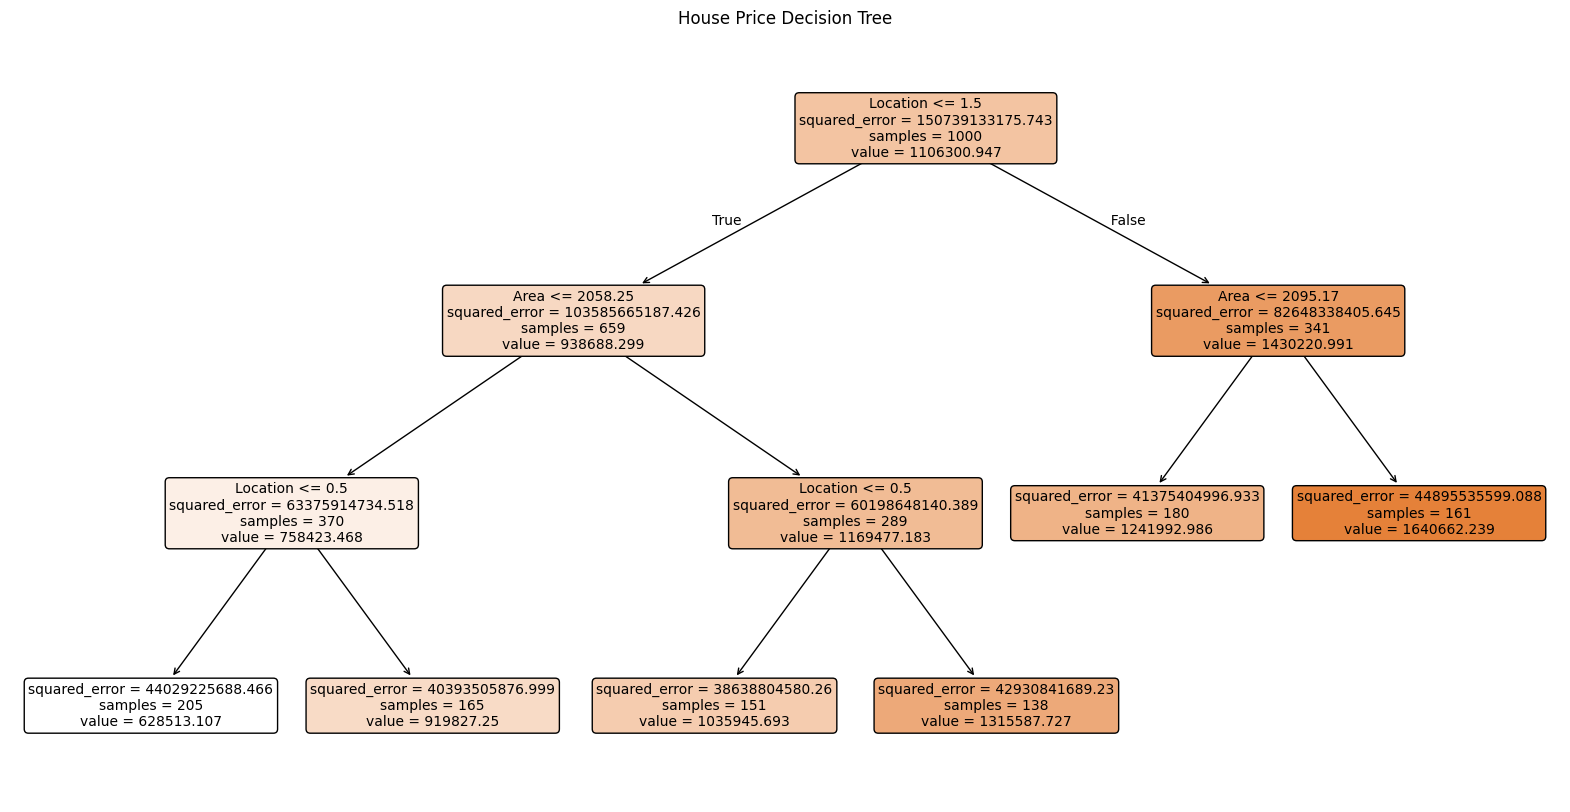

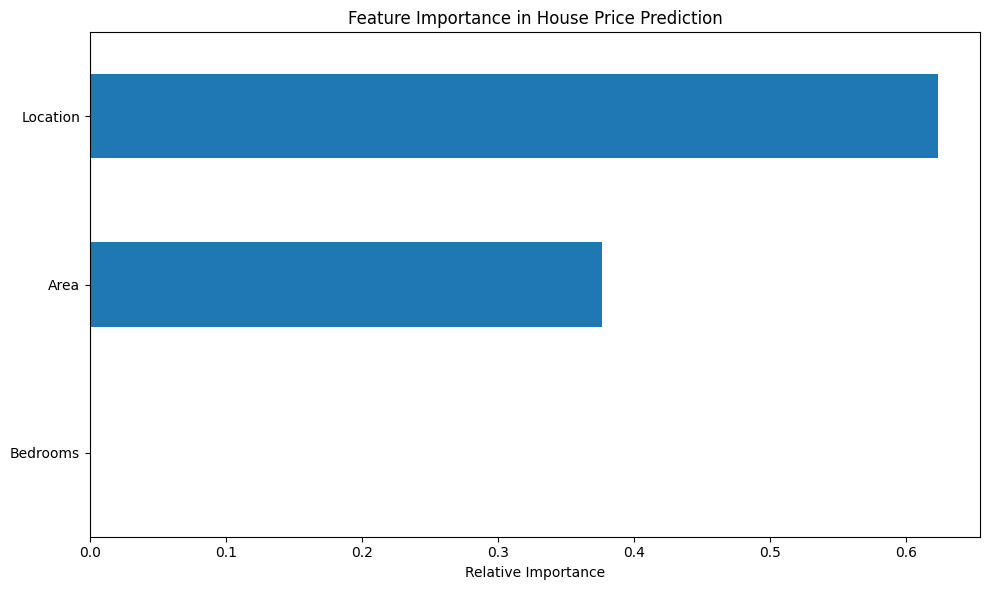

In [89]:
# Create sample data
np.random.seed(42)
n_samples = 1000

# Generate features
area = np.random.normal(2000, 500, n_samples)
bedrooms = np.random.randint(1, 6, n_samples)
location_code = np.random.randint(0, 3, n_samples)  # 0: Other, 1: Chelsea, 2: Mayfair

# Generate target (house prices)
base_price = 500000
area_impact = (area - 2000) * 500
bedroom_impact = bedrooms * 100000
location_impact = location_code * 300000
noise = np.random.normal(0, 50000, n_samples)

price = base_price + area_impact + bedroom_impact + location_impact + noise

# Create and fit the model
X = np.column_stack([area, bedrooms, location_code])
model = DecisionTreeRegressor(max_depth=3, min_samples_leaf=100)
model.fit(X, price)

# Plot the tree
plt.figure(figsize=(20,10))
plot_tree(model, 
          feature_names=['Area', 'Bedrooms', 'Location'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('House Price Decision Tree')
plt.show()

# Plot feature importances
importances = pd.Series(model.feature_importances_,
                       index=['Area', 'Bedrooms', 'Location'])
plt.figure(figsize=(10,6))
importances.sort_values().plot(kind='barh')
plt.title('Feature Importance in House Price Prediction')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

## Understanding Bias, Variance, Tree Depth and Complexity

### Bias
- **The error introduced by approximating a real-world problem with a simplified model**
- Represents how far off the model's predictions are from the true values on average
- High bias means the model consistently misses the true patterns (underfitting)

    1. **Shallow Trees (High Bias)**
    ```pre
    Root: Area > 2000 sq ft?
    ├── Yes: £2M
    └── No: £800K
    ```
    - Very simple rules
    - Misses many important factors
    - Similar predictions for different houses

### Variance
- **The model's sensitivity to fluctuations in the training data**
- Represents how much predictions change with different training sets
- High variance means predictions vary significantly with small changes in training data (overfitting)

    2. **Deep Trees (High Variance)**
    ```pre
    Root: Area > 2000 sq ft?
    ├── Yes: Location = "Chelsea"?
    │   ├── Yes: Bedrooms > 3?
    │   │   ├── Yes: Garden = True?
    │   │   │   ├── Yes: £3.2M
    │   │   │   └── No: £2.9M
    ...
    ```
    - Very specific rules
    - Might memorize training data
    - Can make unstable predictions

## Identifying the Bias/Variance Tradeoff

Consider these scenarios:

### Scenario 1: Too Simple (High Bias)
```python
# Example of underfitting
predictions = {
    "2500 sq ft in Chelsea": £2M,
    "2500 sq ft in Hackney": £2M,  # Same prediction despite location
    "2500 sq ft in Mayfair": £2M   # Location ignored
}
```

### Scenario 2: Too Complex (High Variance)
```python
# Example of overfitting
predictions = {
    "2500 sq ft, Chelsea, 4 bed, garden": £3.2M,
    "2500 sq ft, Chelsea, 4 bed, no garden": £2.9M,
    # Small changes lead to large prediction differences
    "2499 sq ft, Chelsea, 4 bed, garden": £2.7M  # Just 1 sq ft difference
}
```

### Scenario 3: Balanced
```python
# Example of good balance
predictions = {
    "Large house in Chelsea": £2.5M-3.0M,
    "Large house in Hackney": £1.5M-2.0M,
    # Reasonable variations based on key features
}
```

## Managing the Bias/Variance Tradeoff

When building a decision tree, we need to find the right balance between making it too simple (underfitting) and too complex (overfitting). 

Let's explore how to find this balance.

### 1. Control Tree Complexity
We can control how detailed our tree becomes using parameters:
- Maximum depth (how many questions we can ask)
- Minimum samples per leaf (how many houses needed for a conclusion)
- Minimum improvement threshold (how much better a split needs to be)

### 2. Understanding Training vs Validation Error

Training error is how well our model predicts house prices for houses it learned from, while validation error is how well it predicts prices for houses it hasn't seen before.

Think of it like this:
- **Training Error**: How well you can predict prices of houses you studied
- **Validation Error**: How well you can predict prices of new houses

Let's look at how these errors change as we make our tree more complex:

```code
Depth   Training Error  Validation Error   What's Happening
3       £250K           £260K              #  Tree is too simple
                                           #  - Both errors are high
                                           #  - Tree isn't learning enough patterns
 
5       £180K           £200K              #  Tree is just right
                                           #  - Both errors are reasonable
                                           #  - Tree learns genuine patterns
 
7       £120K           £220K              #  Tree is getting too complex
                                           #  - Training error keeps dropping
                                           #  - Validation error starts rising
                                           #  - Starting to memorise training data
 
10      £50K            £300K              #  Tree is way too complex
                                           #  - Training error is very low
                                           #  - Validation error is very high
                                           #  - Tree has memorised training data
```

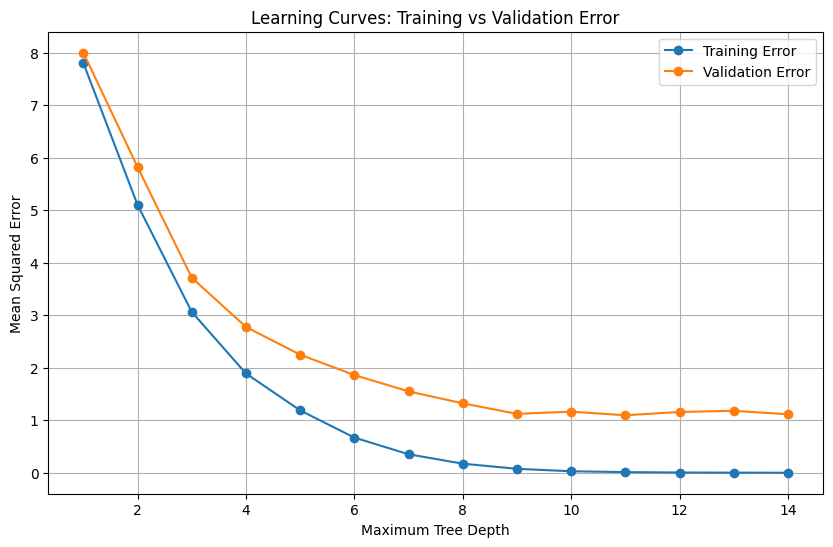

Optimal tree depth: 11


In [90]:
# Generate sample housing data
np.random.seed(42)
n_samples = 1000

# Features
X = np.random.randn(n_samples, 3)  # area, bedrooms, location_score
# True price function with some noise
y = (3 * X[:, 0] + 2 * X[:, 1] + X[:, 2] + 
     0.2 * (X[:, 0] ** 2) + 0.1 * (X[:, 1] ** 2) + 
     np.random.randn(n_samples) * 0.1)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Test different depths
max_depths = range(1, 15)
train_errors = []
val_errors = []

for depth in max_depths:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    train_pred = tree.predict(X_train)
    val_pred = tree.predict(X_val)
    
    train_errors.append(mean_squared_error(y_train, train_pred))
    val_errors.append(mean_squared_error(y_val, val_pred))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_errors, 'o-', label='Training Error')
plt.plot(max_depths, val_errors, 'o-', label='Validation Error')
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curves: Training vs Validation Error')
plt.legend()
plt.grid(True)
plt.show()

# Find optimal depth
optimal_depth = max_depths[np.argmin(val_errors)]
print(f"Optimal tree depth: {optimal_depth}")

## Visual Indicators of Bias/Variance

### 1. Learning Curves

![model-complexity-bias-variance-contributing-to-total-error](../static/images/model-complexity-bias-variance-contributing-to-total-error.png)

As the model complexity increases, the training error decreases and the validation error increases. 

Total error is the sum of bias (the error introduced by approximating a real-world problem with a simplified model) and variance (the error caused by the model's sensitivity to fluctuations in the training data).

Underfitting occurs when the model is too simple (high bias), resulting in both training set and validation set total errors being high.

Overfitting occurs when the model is too complex (high variance), resulting in a large gap between training and validation set total errors.

![model-complexity-error-training-test-samples](../static/images/model-complexity-error-training-test-samples.png)

![performance-model-complexity-training-validation-sets-overfitting](../static/images/performance-model-complexity-training-validation-sets-overfitting.png)

## Practical Guidelines

1. **Start Simple**
   - Begin with shallow trees
   - Add complexity gradually
   - Monitor performance changes

2. **Use Domain Knowledge**
   - Consider reasonable decision granularity
   - Identify important feature interactions
   - Set meaningful constraints

3. **Regular Validation**
   - Test on unseen data
   - Check prediction stability
   - Monitor for overfitting signs

Understanding this tradeoff is crucial for:
- Setting appropriate tree depth
- Choosing regularization parameters
- Deciding when to use ensemble methods

Now that we understand how to build well-balanced decision trees, we need to know which features are driving their decisions. 

In the next section, we'll explore how decision trees determine which features are most important for making predictions (like whether location matters more than size for house prices) and discover their advanced capabilities in handling different types of data. This knowledge is crucial for building more effective models and gaining insights from your data.

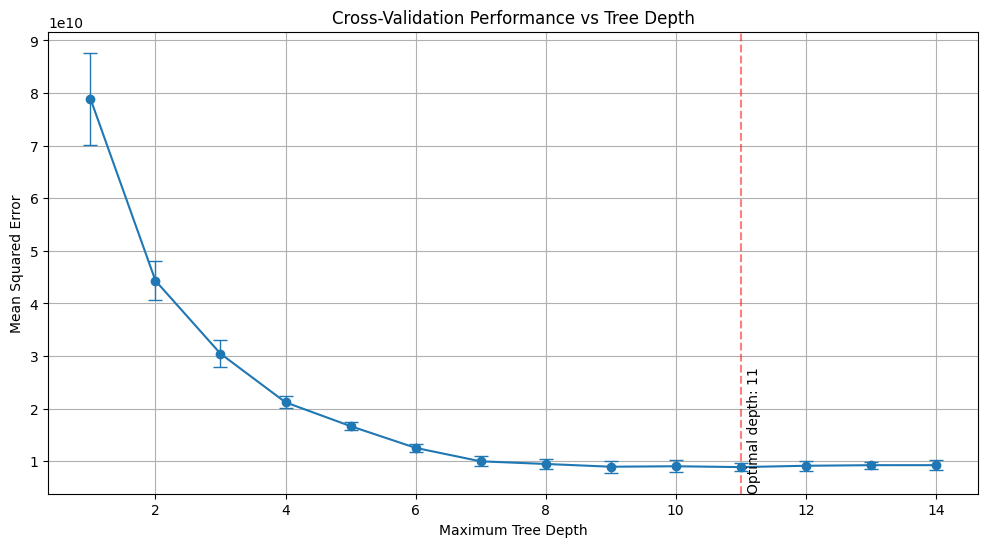

Best CV Score (MSE): £8,880,432,793.36


In [91]:
def analyze_tree_complexity(X, y, max_depths=range(1, 15), cv=5):
    """Analyze decision tree performance across different depths using cross-validation."""
    cv_scores_mean = []
    cv_scores_std = []
    
    for depth in max_depths:
        tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
        scores = cross_val_score(tree, X, y, cv=cv, scoring='neg_mean_squared_error')
        cv_scores_mean.append(-scores.mean())  # Convert back to positive MSE
        cv_scores_std.append(scores.std())
    
    # Plot results with error bars
    plt.figure(figsize=(12, 6))
    plt.errorbar(max_depths, cv_scores_mean, yerr=cv_scores_std, 
                fmt='o-', capsize=5, capthick=1, elinewidth=1)
    plt.xlabel('Maximum Tree Depth')
    plt.ylabel('Mean Squared Error')
    plt.title('Cross-Validation Performance vs Tree Depth')
    plt.grid(True)
    
    # Find optimal depth
    optimal_depth = max_depths[np.argmin(cv_scores_mean)]
    plt.axvline(optimal_depth, color='r', linestyle='--', alpha=0.5)
    plt.text(optimal_depth + 0.1, plt.ylim()[0], f'Optimal depth: {optimal_depth}',
             rotation=90, verticalalignment='bottom')
    
    plt.show()
    return optimal_depth, min(cv_scores_mean)

# Example usage with housing data
np.random.seed(42)
n_samples = 1000

# Generate features with realistic relationships
area = np.random.normal(2000, 500, n_samples)  # Area in sq ft
bedrooms = np.random.randint(1, 6, n_samples)  # Number of bedrooms
location_score = np.random.uniform(0, 1, n_samples)  # Location desirability

# Generate prices with non-linear relationships and interaction effects
base_price = 500000
price = (base_price + 
         area * 200 * (1 + location_score) +  # Area effect varies by location
         bedrooms * 50000 * (1 + 0.5 * location_score) +  # Bedroom effect also varies
         location_score * 1000000 +  # Direct location effect
         np.random.normal(0, 50000, n_samples))  # Random noise

X = np.column_stack([area, bedrooms, location_score])
optimal_depth, best_score = analyze_tree_complexity(X, price)
print(f"Best CV Score (MSE): £{best_score:,.2f}")

# Feature Importance and Advanced Tree-Based Methods

After exploring the fundamentals of decision trees, we'll examine how they evaluate feature importance and how this understanding leads to more sophisticated tree-based methods. This progression builds toward ATLAS (Automated Tree Learning Analysis System) through:

1. Understanding how decision trees determine feature importance
2. Recognizing the limitations that motivated ensemble methods
3. Building up to Random Forests - the foundation of parallel tree ensembles
4. Understanding sequential learning with Gradient Boosting and XGBoost

These concepts directly inform ATLAS's model selection and comparison strategies.

## Mathematical Foundation of Feature Importance

Decision trees provide a natural measure of feature importance based on how much each feature contributes to reducing prediction error. For a feature $f$, its importance is calculated as:

$importance(f) = \sum_{nodes\:using\:f} \frac{n_{node}}{N} \cdot (impurity_{before} - impurity_{after})$

where:
- $n_{node}$ is the number of samples reaching the node
- $N$ is the total number of samples
- $impurity_{before}$ is the node's impurity before splitting
- $impurity_{after}$ is the weighted sum of child node impurities

For house price prediction:
- $impurity_{before}$ is the variance of house prices at a node
- The split that maximizes impurity reduction is chosen
- Features that create purer groups (more similar prices) get higher importance

### Properties of Feature Importance

1. **Scale Independence**
   - Importance measures are relative
   - Sum to 1 across all features
   - Independent of feature scales

2. **Hierarchy Effect**
   - Splits near root affect more samples
   - Early splits tend to use most important features
   - Deep splits have limited impact on overall importance

3. **Interaction Capture**
   - Features that work well together get high importance
   - Accounts for non-linear relationships
   - Reflects real-world feature dependencies


Feature Importance Summary:
age                   0.000000
distance_to_center    0.000000
bedrooms              0.097892
area                  0.257017
location_score        0.645090
dtype: float64

Importance Evolution by Depth:
                    Depth 1   Depth 2   Depth 3   Depth 4   Depth 5
area                    0.0  0.272289  0.225858  0.211675  0.257017
bedrooms                0.0  0.000000  0.031254  0.098219  0.097892
location_score          1.0  0.727711  0.742889  0.690106  0.645090
age                     0.0  0.000000  0.000000  0.000000  0.000000
distance_to_center      0.0  0.000000  0.000000  0.000000  0.000000


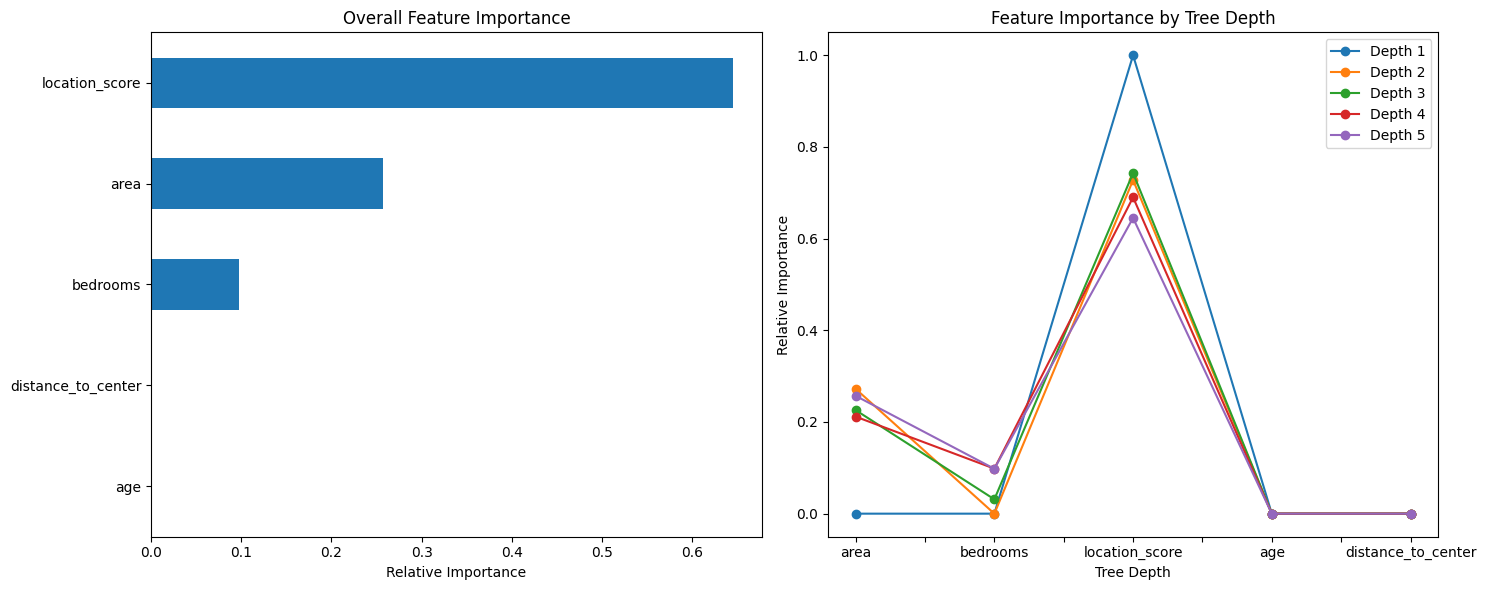

In [92]:
def analyze_feature_importance(X, y, max_depth=5):
    """Analyze and visualize feature importance in decision trees"""
    
    # Train the model
    tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    tree.fit(X, y)
    
    # Calculate feature importance
    importance = pd.Series(
        tree.feature_importances_,
        index=X.columns
    ).sort_values(ascending=True)
    
    # Analyze importance at different depths
    importance_by_depth = []
    for depth in range(1, max_depth + 1):
        tree_depth = DecisionTreeRegressor(max_depth=depth, random_state=42)
        tree_depth.fit(X, y)
        importance_depth = pd.Series(
            tree_depth.feature_importances_,
            index=X.columns
        )
        importance_by_depth.append(importance_depth)
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Overall importance
    importance.plot(kind='barh', ax=ax1)
    ax1.set_title('Overall Feature Importance')
    ax1.set_xlabel('Relative Importance')
    
    # Importance evolution with depth
    depth_df = pd.DataFrame(importance_by_depth).T
    depth_df.columns = [f'Depth {i+1}' for i in range(max_depth)]
    depth_df.plot(ax=ax2, marker='o')
    ax2.set_title('Feature Importance by Tree Depth')
    ax2.set_xlabel('Tree Depth')
    ax2.set_ylabel('Relative Importance')
    
    plt.tight_layout()
    return importance, depth_df

# Generate example housing data
np.random.seed(42)
n_samples = 1000

# Features with known relationships
X = pd.DataFrame({
    'area': np.random.normal(2000, 500, n_samples),
    'bedrooms': np.random.randint(1, 6, n_samples),
    'location_score': np.random.uniform(0, 1, n_samples),
    'age': np.random.randint(0, 50, n_samples),
    'distance_to_center': np.random.uniform(1, 20, n_samples)
})

# Generate prices with known importance relationships
y = (
    X['area'] * 200 +  # Strong effect
    X['location_score'] * 500000 +  # Very strong effect
    X['bedrooms'] * 50000 +  # Moderate effect
    X['age'] * -1000 +  # Weak effect
    X['distance_to_center'] * -5000 +  # Medium effect
    np.random.normal(0, 50000, n_samples)  # Noise
)

# Analyze importance
importance, importance_by_depth = analyze_feature_importance(X, y)

print("\nFeature Importance Summary:")
print(importance)

print("\nImportance Evolution by Depth:")
print(importance_by_depth)

## Random Forests: Ensemble Learning from First Principles

Random Forests address the fundamental limitations of single decision trees through statistical principles of ensemble learning. Let's build up the concept from first principles.

### The Variance Problem

Consider a single decision tree trained on house price data. If we train it on slightly different datasets, we get significantly different trees:

```
Dataset 1 Tree:              Dataset 2 Tree:
area > 2000?                 location_score > 0.7?
├── Yes: £2.5M              ├── Yes: £2.8M
└── No: bedrooms > 3?       └── No: area > 1800?
```

This high variance means:
- Small data changes → large model changes
- Overfitting to training data
- Poor generalization

### Statistical Solution: Averaging Independent Predictions

If we have multiple independent predictions $\hat{y}_1, \hat{y}_2, ..., \hat{y}_m$, their average has lower variance:

$Var(\frac{1}{m}\sum_{i=1}^m \hat{y}_i) = \frac{\sigma^2}{m}$ (if independent)

But we only have one dataset! This leads to two key innovations:

1. **Bootstrap Sampling**
   - Create multiple datasets by sampling with replacement
   - Each sample is same size as original data
   - ~63.2% unique samples in each bootstrap
   - Remaining ~36.8% are duplicates

2. **Feature Randomization**
   - At each split, consider only random subset of features
   - Makes trees more independent
   - Default size: $\sqrt{p}$ for classification, $p/3$ for regression
   where $p$ is number of features

### Mathematical Foundation

For a Random Forest with $M$ trees:

$\hat{f}_{rf}(x) = \frac{1}{M}\sum_{m=1}^M T_m(x)$

where $T_m(x)$ is the prediction of the $m$th tree.

The prediction variance is:

$Var(\hat{f}_{rf}) = \rho \sigma^2 + \frac{1-\rho}{M}\sigma^2$

where:
- $\rho$ is the correlation between trees
- $\sigma^2$ is the variance of individual trees

This shows:
- More trees ($M \uparrow$) → lower variance
- Lower correlation ($\rho \downarrow$) → lower variance
- Feature randomization reduces $\rho$

Prediction Variance:
Single Tree: 2,992,986,680
Random Forest: 529,136,067
Variance Reduction: 82.3%


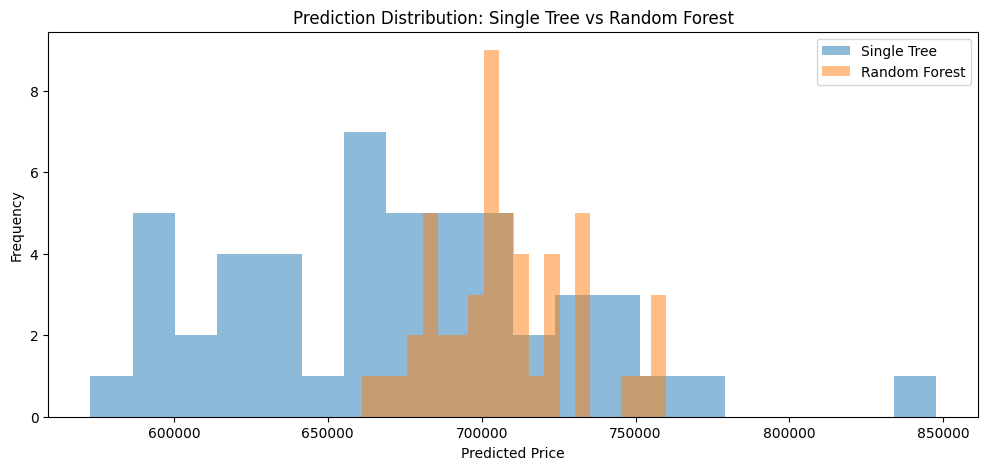

In [93]:
class SimpleRandomForest:
    """Simple Random Forest implementation to demonstrate core concepts"""
    
    def __init__(self, n_trees=100, max_features='sqrt', max_depth=None):
        self.n_trees = n_trees
        self.max_features = max_features
        self.max_depth = max_depth
        self.trees = []
        self.feature_importances_ = None
    
    def _bootstrap_sample(self, X, y):
        """Generate bootstrap sample with replacement"""
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, size=n_samples, replace=True)
        return X.iloc[idxs] if hasattr(X, 'iloc') else X[idxs], y.iloc[idxs] if hasattr(y, 'iloc') else y[idxs]
    
    def fit(self, X, y):
        """Fit random forest using bootstrap samples"""
        self.trees = []
        n_features = X.shape[1]
        
        # Calculate max_features
        if self.max_features == 'sqrt':
            max_features = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            max_features = int(np.log2(n_features))
        else:
            max_features = n_features
            
        # Train each tree on bootstrap sample
        tree_importances = []
        for _ in range(self.n_trees):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree = DecisionTreeRegressor(
                max_features=max_features,
                max_depth=self.max_depth
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
            tree_importances.append(tree.feature_importances_)
        
        # Calculate feature importance as mean across trees
        self.feature_importances_ = np.mean(tree_importances, axis=0)
        
    def predict(self, X):
        """Make predictions by averaging tree predictions"""
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(tree_preds, axis=0)

def compare_tree_vs_forest(X, y, n_experiments=50):
    """Compare variance of single tree vs random forest"""
    single_tree_preds = []
    forest_preds = []
    
    # Generate test point
    X_test = pd.DataFrame([X.mean()]).reset_index(drop=True)
    
    for _ in range(n_experiments):
        # Bootstrap sample
        idxs = np.random.choice(len(X), size=len(X), replace=True)
        X_boot = X.iloc[idxs].reset_index(drop=True)
        y_boot = y.iloc[idxs].reset_index(drop=True)
        
        # Single tree
        tree = DecisionTreeRegressor(max_depth=5)
        tree.fit(X_boot, y_boot)
        single_tree_preds.append(tree.predict(X_test)[0])
        
        # Random forest
        rf = SimpleRandomForest(n_trees=100, max_depth=5)
        rf.fit(X_boot, y_boot)
        forest_preds.append(rf.predict(X_test)[0])
    
    # Plot distributions
    plt.figure(figsize=(12, 5))
    plt.hist(single_tree_preds, alpha=0.5, label='Single Tree', bins=20)
    plt.hist(forest_preds, alpha=0.5, label='Random Forest', bins=20)
    plt.title('Prediction Distribution: Single Tree vs Random Forest')
    plt.xlabel('Predicted Price')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Print statistics
    print('Prediction Variance:')
    print(f'Single Tree: {np.var(single_tree_preds):,.0f}')
    print(f'Random Forest: {np.var(forest_preds):,.0f}')
    print(f'Variance Reduction: {(1 - np.var(forest_preds)/np.var(single_tree_preds))*100:.1f}%')

# Run demonstration
compare_tree_vs_forest(X, y)

## Gradient Boosting and XGBoost: Sequential Learning

While Random Forests reduce variance through parallel ensemble learning, Gradient Boosting takes a sequential approach, building an ensemble by iteratively correcting errors. This leads to a powerful framework that XGBoost further optimizes.

### Core Gradient Boosting Principles

Gradient Boosting builds an ensemble sequentially:
```
Initial Prediction → Error → New Tree → Updated Prediction → Error → New Tree ...
```

For house prices, this means:
1. Make initial prediction (e.g., mean house price)
2. Build tree to predict the errors
3. Add scaled tree predictions to current predictions
4. Repeat process focusing on remaining errors

### Mathematical Foundation

For a house price prediction problem:

1. **Initial Prediction**:
   $F_0(x) = \text{avg}(\text{price})$

2. **For each iteration** $m = 1$ to $M$:
   - Compute residuals: $r_i = y_i - F_{m-1}(x_i)$
   - Fit new tree: $h_m(x)$ to predict residuals
   - Add scaled prediction: $F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)$
   
   where $\nu$ is the learning rate (typically 0.1)

3. **Final Prediction**:
   $F_M(x) = F_0(x) + \sum_{m=1}^M \nu \cdot h_m(x)$

This process ensures each new tree focuses on the mistakes of the ensemble so far.

### XGBoost Innovations

XGBoost enhances gradient boosting through several key innovations:

1. **Regularized Objective**:
   ```
   Objective = Loss + Regularization
   ```
   where regularization penalizes complex trees:
   $\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2$
   - $T$ is number of leaves
   - $w_j$ are leaf weights
   - $\gamma, \lambda$ are regularization parameters

2. **Approximate Split Finding**:
   - Groups continuous features into buckets
   - Evaluates splits only at bucket boundaries
   - Makes training much faster
   - Minimal accuracy impact

3. **System Optimizations**:
   - Cache-aware access
   - Parallel processing
   - Out-of-core computing
   - Distributed training support

These innovations make XGBoost particularly effective for house price prediction, as it can:
- Handle non-linear relationships efficiently
- Manage high-dimensional feature spaces
- Process large housing datasets quickly
- Provide robust predictions with good generalization

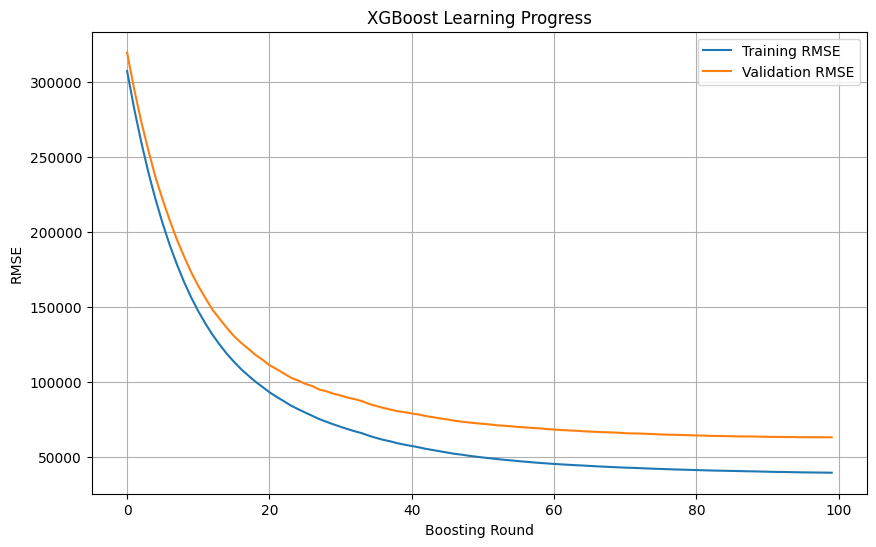

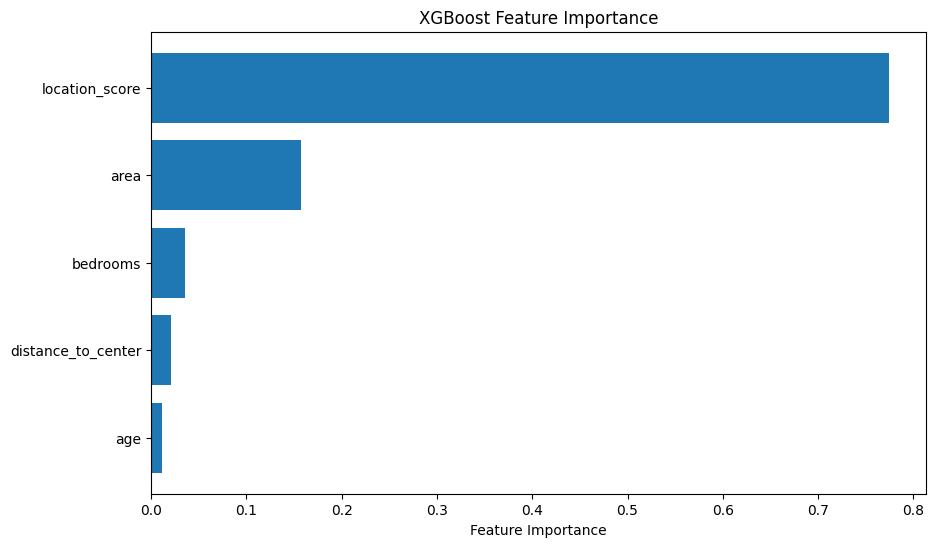


Final Performance:
Training RMSE: £39,548.88
Validation RMSE: £63,148.86

Feature Importance Summary:
           feature  importance
               age    0.011752
distance_to_center    0.020796
          bedrooms    0.035192
              area    0.157496
    location_score    0.774764


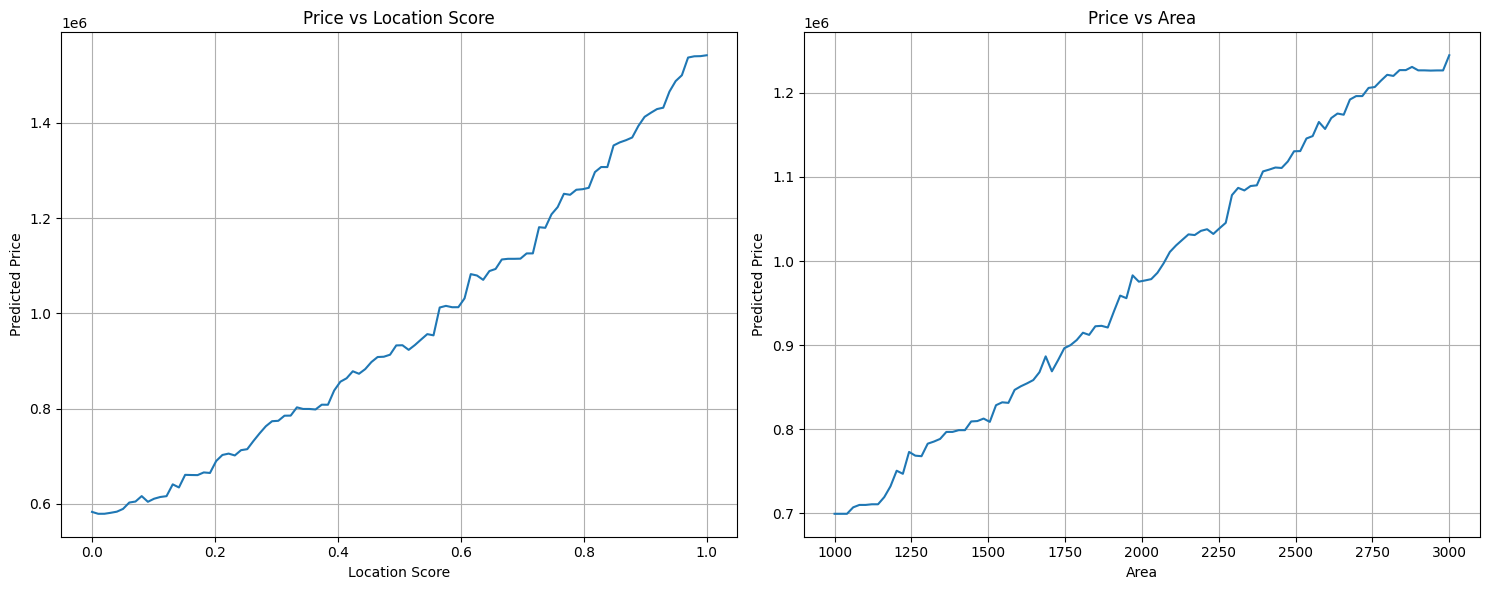

In [94]:
class GradientBoostingAnalyzer:
    """Demonstrates and analyzes gradient boosting behavior"""
    
    def __init__(self, n_estimators=100, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.model = xgb.XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=3,
            reg_lambda=1,
            random_state=42
        )
        
    def analyze_residuals(self, X, y):
        """Visualize how boosting reduces residuals over iterations"""
        residuals = []
        for i in range(1, self.n_estimators + 1):
            model_partial = xgb.XGBRegressor(
                n_estimators=i,
                learning_rate=self.learning_rate,
                max_depth=3,
                reg_lambda=1,
                random_state=42
            )
            model_partial.fit(X, y)
            pred = model_partial.predict(X)
            residuals.append(np.abs(y - pred).mean())
        return residuals
        
    def analyze_boosting_progress(self, X, y):
        """Analyze learning progression with validation"""
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42)
        
        # Convert to DMatrix format for XGBoost
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        
        # Set parameters
        params = {
            'max_depth': 3,
            'learning_rate': self.learning_rate,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse'
        }
        
        # Train model with evaluation
        evals_result = {}
        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=self.n_estimators,
            evals=[(dtrain, 'train'), (dval, 'val')],
            evals_result=evals_result,
            verbose_eval=False
        )
        
        # Extract training and validation RMSE
        train_rmse = evals_result['train']['rmse']
        val_rmse = evals_result['val']['rmse']
        
        # Plot learning curves
        plt.figure(figsize=(10, 6))
        plt.plot(train_rmse, label='Training RMSE')
        plt.plot(val_rmse, label='Validation RMSE')
        plt.xlabel('Boosting Round')
        plt.ylabel('RMSE')
        plt.title('XGBoost Learning Progress')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        return train_rmse, val_rmse
    
    def analyze_feature_importance(self, X, y):
        """Analyze and visualize feature importance"""
        # Fit the model
        self.model.fit(X, y)
        
        # Get feature importance
        importance = self.model.feature_importances_
        importance_df = pd.DataFrame({
            'feature': X.columns,
            'importance': importance
        }).sort_values('importance', ascending=True)
        
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['feature'], importance_df['importance'])
        plt.xlabel('Feature Importance')
        plt.title('XGBoost Feature Importance')
        plt.show()
        
        return importance_df

def analyze_nonlinear_effects(X, y):
    """Analyze how XGBoost captures non-linear relationships"""
    model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    # Create grid for partial dependence plots
    feature_grids = {
        'location_score': np.linspace(0, 1, 100),
        'area': np.linspace(1000, 3000, 100)
    }
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot partial dependence for each feature
    for i, (feature, grid) in enumerate(feature_grids.items()):
        predictions = []
        for value in grid:
            X_temp = X.copy()
            X_temp[feature] = value
            pred = model.predict(X_temp)
            predictions.append(np.mean(pred))
            
        ax = axes[i]
        ax.plot(grid, predictions)
        ax.set_title(f'Price vs {feature.replace("_", " ").title()}')
        ax.set_xlabel(feature.replace("_", " ").title())
        ax.set_ylabel('Predicted Price')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Generate sample data
np.random.seed(42)
n_samples = 1000

# Generate features
X = pd.DataFrame({
    'area': np.random.normal(2000, 500, n_samples),
    'bedrooms': np.random.randint(1, 6, n_samples),
    'location_score': np.random.uniform(0, 1, n_samples),
    'age': np.random.randint(0, 50, n_samples),
    'distance_to_center': np.random.uniform(1, 20, n_samples)
})

# Generate target with non-linear effects and interactions
y = (
    X['area'] * 200 * (1 + X['location_score']) +  # Interaction effect
    X['bedrooms'] * 50000 * (1.1 - X['distance_to_center']/20) +  # Another interaction
    np.exp(X['location_score'] * 2) * 100000 +  # Non-linear effect
    X['age'] * -1000 * (1 + X['location_score']) +  # Age penalty varies by location
    np.random.normal(0, 50000, n_samples)  # Random noise
)

# Initialize analyzer
analyzer = GradientBoostingAnalyzer(n_estimators=100)

# Analyze boosting behavior
train_rmse, val_rmse = analyzer.analyze_boosting_progress(X, y)

# Analyze feature importance
importance_df = analyzer.analyze_feature_importance(X, y)

print("\nFinal Performance:")
print(f"Training RMSE: £{train_rmse[-1]:,.2f}")
print(f"Validation RMSE: £{val_rmse[-1]:,.2f}")

print("\nFeature Importance Summary:")
print(importance_df.to_string(index=False))

# Analyze non-linear relationships
analyze_nonlinear_effects(X, y)

In [95]:
class TreeMethodsComparison:
    """Comprehensive comparison of tree-based methods for house price prediction"""
    
    def __init__(self):
        self.models = {
            'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
        }
        self.results = {}
        
    def compare_performance(self, X: pd.DataFrame, y: pd.Series) -> Dict:
        """Compare performance metrics across models"""
        performance = {}
        
        for name, model in self.models.items():
            # Cross validation scores
            cv_scores = cross_val_score(
                model, X, y, 
                cv=5, 
                scoring='neg_mean_squared_error'
            )
            rmse_scores = np.sqrt(-cv_scores)
            
            performance[name] = {
                'mean_rmse': rmse_scores.mean(),
                'std_rmse': rmse_scores.std(),
                'cv_scores': rmse_scores
            }
            
        self.results['performance'] = performance
        return performance
    
    def compare_feature_importance(self, X: pd.DataFrame, y: pd.Series) -> Dict:
        """Compare feature importance across models"""
        importance = {}
        
        for name, model in self.models.items():
            # Fit model
            model.fit(X, y)
            
            # Get feature importance
            if hasattr(model, 'feature_importances_'):
                importance[name] = dict(zip(
                    X.columns,
                    model.feature_importances_
                ))
        
        self.results['importance'] = importance
        return importance
    
    def visualize_results(self):
        """Create visualizations comparing model performance"""
        # Performance comparison
        plt.figure(figsize=(15, 5))
        
        # Plot 1: RMSE comparison
        plt.subplot(121)
        perf = self.results['performance']
        models = list(perf.keys())
        rmse_means = [p['mean_rmse'] for p in perf.values()]
        rmse_stds = [p['std_rmse'] for p in perf.values()]
        
        plt.bar(models, rmse_means, yerr=rmse_stds)
        plt.title('RMSE by Model Type')
        plt.xticks(rotation=45)
        plt.ylabel('RMSE (£)')
        
        # Plot 2: Feature importance comparison
        plt.subplot(122)
        importance = self.results['importance']
        feature_df = pd.DataFrame(importance)
        
        sns.heatmap(feature_df, annot=True, fmt='.2f', cmap='YlOrRd')
        plt.title('Feature Importance Comparison')
        plt.xlabel('Model')
        plt.ylabel('Feature')
        
        plt.tight_layout()
        plt.show()
        
    def predict_price_range(self, X: pd.DataFrame) -> Dict[str, np.ndarray]:
        """Compare prediction ranges across models"""
        predictions = {}
        
        for name, model in self.models.items():
            pred = model.predict(X)
            predictions[name] = pred
            
        return predictions


Performance Comparison:

Decision Tree:
Mean RMSE: £127,635.55 (±8,087.98)

Random Forest:
Mean RMSE: £73,065.64 (±6,112.87)

XGBoost:
Mean RMSE: £71,148.70 (±4,616.11)

Feature Importance by Model:
                    Decision Tree  Random Forest   XGBoost
area                     0.156123       0.164109  0.114411
bedrooms                 0.045428       0.045351  0.092189
location_score           0.798449       0.775881  0.783003
age                      0.000000       0.007520  0.005746
distance_to_center       0.000000       0.007138  0.004651


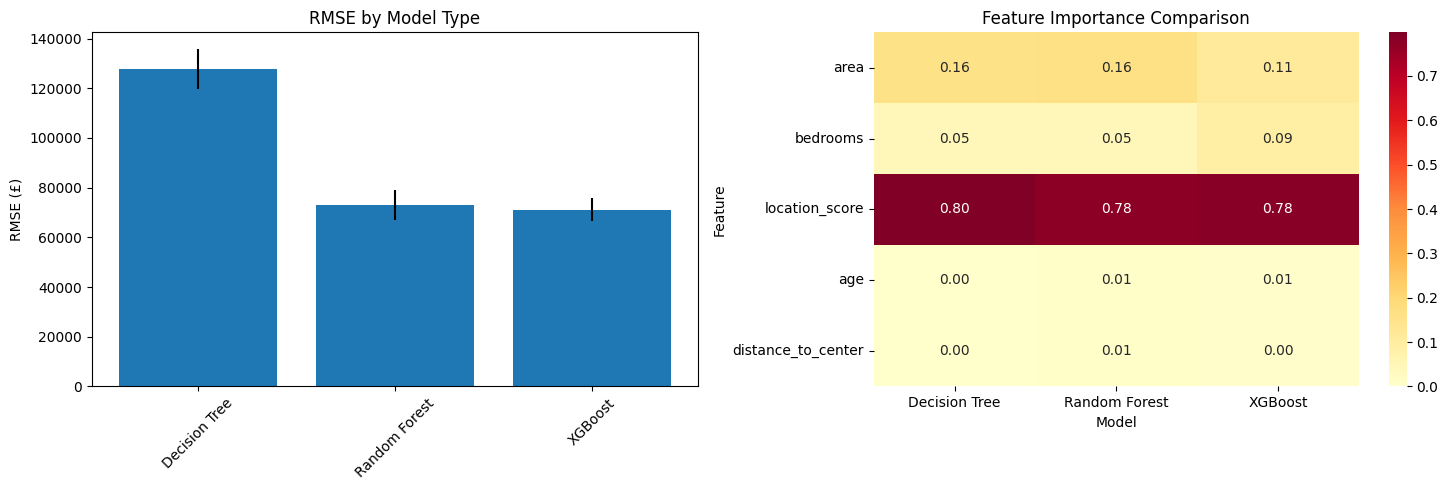


Prediction Comparison for Test Cases:
   Decision Tree  Random Forest      XGBoost
0   7.346046e+05   6.627598e+05   665621.000
1   1.418410e+06   1.438506e+06  1483947.125
2   1.880112e+06   2.018973e+06  2001708.250


In [96]:
# Generate example housing data
np.random.seed(42)
n_samples = 1000

# Features with realistic relationships
X = pd.DataFrame({
    'area': np.random.normal(2000, 500, n_samples),
    'bedrooms': np.random.randint(1, 6, n_samples),
    'location_score': np.random.uniform(0, 1, n_samples),
    'age': np.random.randint(0, 50, n_samples),
    'distance_to_center': np.random.uniform(1, 20, n_samples)
})

# Generate prices with non-linear relationships and interactions
y = (
    X['area'] * 200 * (1 + X['location_score']) +  # Area-location interaction
    X['bedrooms'] * 50000 * (1 + 0.5 * X['location_score']) +  # Bedroom-location interaction
    np.exp(X['location_score'] * 2) * 100000 +  # Non-linear location effect
    X['age'] * -1000 * (1 + X['location_score']) +  # Age penalty varies by location
    np.random.normal(0, 50000, n_samples)  # Random noise
)

# Initialize comparison
comparison = TreeMethodsComparison()

# Compare performance
performance = comparison.compare_performance(X, y)
print("\nPerformance Comparison:")
for model, metrics in performance.items():
    print(f"\n{model}:")
    print(f"Mean RMSE: £{metrics['mean_rmse']:,.2f} (±{metrics['std_rmse']:,.2f})")

# Compare feature importance
importance = comparison.compare_feature_importance(X, y)
print("\nFeature Importance by Model:")
importance_df = pd.DataFrame(importance)
print(importance_df)

# Visualize comparisons
comparison.visualize_results()

# Compare predictions for specific examples
test_cases = pd.DataFrame({
    'area': [1500, 2500, 3500],
    'bedrooms': [2, 3, 4],
    'location_score': [0.3, 0.7, 0.9],
    'age': [20, 10, 5],
    'distance_to_center': [15, 8, 3]
})

predictions = comparison.predict_price_range(test_cases)
print("\nPrediction Comparison for Test Cases:")
pred_df = pd.DataFrame(predictions)
print(pred_df)

## Ethical Considerations for Decision Tree Models

When applying decision trees to housing price prediction, we must carefully consider the ethical implications and societal impact of our models.

### 1. Bias in Training Data

#### Understanding Data Bias

Historical housing data often reflects societal inequalities and biases:
- Certain areas may be over or under-represented
- Quality of data may vary by neighborhood
- Historical redlining effects may persist in the data
- Property features may be inconsistently recorded across areas

#### Example of Data Bias
Consider two neighborhoods:

**Affluent Area:**
- 1000+ property records
- Complete feature sets (area, condition, amenities)
- Regular price updates
- Detailed property descriptions

**Developing Area:**
- Only 100 property records
- Missing features
- Irregular price updates
- Basic property information only

This disparity in data quality and quantity can lead to:
- Less accurate predictions in underrepresented areas
- Reinforcement of existing price disparities
- Lower confidence in predictions for certain areas

#### Mitigation Strategies

1. **Data Collection**
   - Actively gather data from underrepresented areas
   - Standardize data collection across all neighborhoods
   - Partner with community organizations for local insights

2. **Model Development**
   - Weight samples to balance representation
   - Use stratified sampling across neighborhoods
   - Include confidence intervals with predictions

3. **Regular Auditing**
   - Monitor prediction accuracy across different areas
   - Track error rates by neighborhood
   - Assess impact on different communities

### 2. Fairness and Discrimination

#### Protected Characteristics

Decision trees must not perpetuate discrimination based on:
- Race, ethnicity, or national origin
- Religion
- Gender
- Age
- Disability status
- Family status

#### Direct and Indirect Bias

Consider these two approaches:

**Problematic Approach:**
```pre
If neighborhood = "historically_disadvantaged":
    Predict lower value
```

**Better Approach:**
```pre
If distance_to_amenities < 1km:
    If property_condition = "excellent":
        Predict based on objective features
```

The second approach uses objective criteria rather than potentially biased historical patterns.

#### Monitoring for Fairness

1. Track prediction ratios across different groups
2. Compare error rates between communities
3. Analyze the impact of model updates on different areas
4. Review feature importance for potential proxy discrimination

Fairness Analysis by Neighborhood:
   count  mean_error  mape  avg_prediction  avg_actual
A  497.0   103109.86  0.72       188913.61   180601.20
C  194.0   108773.61  0.61       175880.50   198025.66
B  309.0   114988.36  0.73       209854.80   186152.21


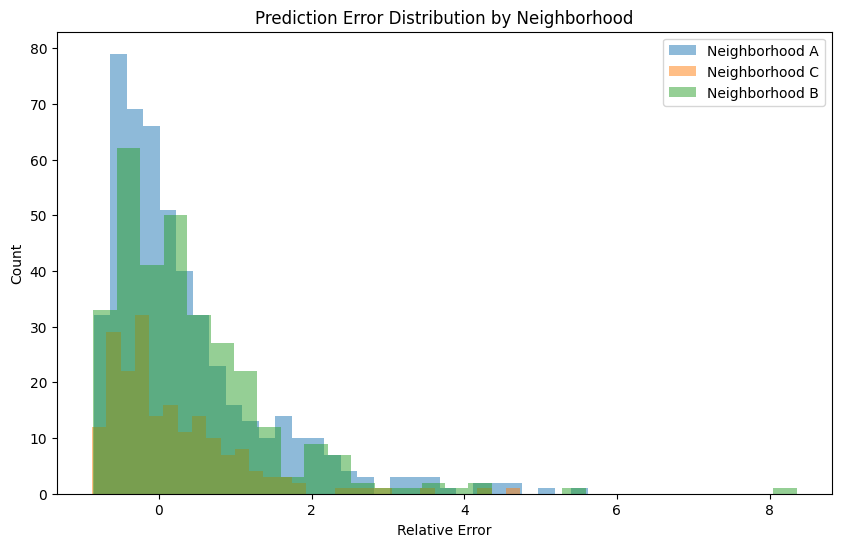

In [97]:
class FairnessMonitor:
    def __init__(self):
        self.metrics = {}
        self.error_distributions = {}
    
    def analyze_predictions(self, y_true, y_pred, groups):
        """Analyze prediction fairness across different groups"""
        group_metrics = {}
        
        for group_name in groups.unique():
            mask = groups == group_name
            
            # Calculate metrics for this group
            metrics = {
                'count': sum(mask),
                'mean_error': np.mean(np.abs(y_true[mask] - y_pred[mask])),
                'mape': mean_absolute_percentage_error(y_true[mask], y_pred[mask]),
                'avg_prediction': np.mean(y_pred[mask]),
                'avg_actual': np.mean(y_true[mask])
            }
            
            group_metrics[group_name] = metrics
        
        return pd.DataFrame(group_metrics).T

# Example usage
np.random.seed(42)
n_samples = 1000

# Generate sample data
data = {
    'actual_price': np.random.lognormal(12, 0.5, n_samples),
    'predicted_price': np.random.lognormal(12, 0.5, n_samples),
    'neighborhood': np.random.choice(['A', 'B', 'C'], n_samples,
                                    p=[0.5, 0.3, 0.2])
}

df = pd.DataFrame(data)

# Add some systematic bias
bias_factor = {
    'A': 1.0,   # No bias
    'B': 1.1,   # 10% overprediction
    'C': 0.9    # 10% underprediction
}

for neighborhood, factor in bias_factor.items():
    mask = df['neighborhood'] == neighborhood
    df.loc[mask, 'predicted_price'] *= factor

# Analyze fairness
monitor = FairnessMonitor()
fairness_metrics = monitor.analyze_predictions(
    df['actual_price'],
    df['predicted_price'],
    df['neighborhood']
)

print("Fairness Analysis by Neighborhood:")
print(fairness_metrics.round(2))

# Visualize error distributions
plt.figure(figsize=(10, 6))
for neighborhood in df['neighborhood'].unique():
    mask = df['neighborhood'] == neighborhood
    errors = (df.loc[mask, 'predicted_price'] - 
             df.loc[mask, 'actual_price']) / df.loc[mask, 'actual_price']
    plt.hist(errors, alpha=0.5, label=f'Neighborhood {neighborhood}',
             bins=30)

plt.title('Prediction Error Distribution by Neighborhood')
plt.xlabel('Relative Error')
plt.ylabel('Count')
plt.legend()
plt.show()

### 3. Market Impact and Social Responsibility

#### Housing Market Effects

Our models can influence:
1. **Buyer Behaviour**
   - Setting price expectations
   - Influencing negotiation starting points
   - Affecting perceived neighborhood value

2. **Market Dynamics**
   - Property valuation standards
   - Investment patterns
   - Neighborhood development

3. **Housing Accessibility**
   - Affordability assessments
   - Mortgage approvals
   - Insurance rates

#### Responsible Implementation
1. **Transparency**
   - Clearly explain model limitations
   - Provide confidence intervals
   - Document all assumptions
   - Share key factors affecting predictions

2. **Community Impact**
   - Engage with local stakeholders
   - Consider neighborhood stability
   - Monitor displacement risks
   - Support housing accessibility

3. **Market Stability**
   - Avoid reinforcing speculation
   - Maintain price prediction stability
   - Consider local market conditions
   - Support sustainable growth

### 4. Best Practices for Ethical Use

#### Development Guidelines

1. **Data Collection**
   - Ensure representative samples
   - Document data sources
   - Validate data quality
   - Address historical biases

2. **Model Design**
   - Use interpretable features
   - Avoid proxy discrimination
   - Include uncertainty measures
   - Document design choices

3. **Testing and Validation**
   - Test across diverse scenarios
   - Validate with community input
   - Monitor for unintended consequences
   - Regular fairness audits

#### Deployment Considerations
1. **Model Release**
   - Gradual rollout
   - Monitor impact
   - Gather feedback
   - Ready to adjust

2. **Ongoing Oversight**
   - Regular audits
   - Community feedback
   - Impact assessment
   - Update protocols

#### Documentation Requirements

Your model documentation should include:
1. Training data sources and limitations
2. Feature selection rationale
3. Fairness considerations and tests
4. Known biases and limitations
5. Intended use guidelines
6. Impact monitoring plan

Ethical considerations aren't just a compliance checklist—they're fundamental to building models that serve society fairly and responsibly. Regular review and adjustment of these practices ensures our models contribute positively to the housing market and community well-being.

In [98]:
class ModelCard:
    def __init__(self, model_name, version, purpose):
        self.model_name = model_name
        self.version = version
        self.purpose = purpose
        self.creation_date = datetime.now()
        self.model_details = {}
        self.ethical_considerations = {}
        self.performance_metrics = {}
        
    def add_data_description(self, data_description):
        self.data_description = data_description
        
    def add_model_details(self, architecture, parameters):
        self.model_details.update({
            'architecture': architecture,
            'parameters': parameters
        })
        
    def add_ethical_considerations(self, considerations):
        self.ethical_considerations = considerations
        
    def add_performance_metrics(self, metrics):
        self.performance_metrics = metrics
        
    def generate_documentation(self):
        doc = f"""# Model Card: {self.model_name} v{self.version}

## Basic Information
- **Purpose**: {self.purpose}
- **Created**: {self.creation_date.strftime('%Y-%m-%d')}

## Model Details
- **Architecture**: {self.model_details.get('architecture', 'Not specified')}
- **Parameters**: {json.dumps(self.model_details.get('parameters', {}), indent=2)}

## Ethical Considerations
"""        
        for category, details in self.ethical_considerations.items():
            doc += f"\n### {category}\n"
            for item in details:
                doc += f"- {item}\n"
                
        doc += "\n## Performance Metrics\n"
        for metric, value in self.performance_metrics.items():
            doc += f"- **{metric}**: {value}\n"
            
        return doc

# Example usage
model_card = ModelCard(
    model_name="London Housing Price Predictor",
    version="1.0",
    purpose="Predict house prices in London with ethical considerations"
)

model_card.add_model_details(
    architecture="Decision Tree Regressor",
    parameters={
        'max_depth': 5,
        'min_samples_leaf': 50,
        'criterion': 'squared_error'
    }
)

model_card.add_ethical_considerations({
    "Fairness": [
        "Model tested for bias across different neighborhoods",
        "Regular monitoring of prediction disparities",
        "Balanced training data across areas"
    ],
    "Transparency": [
        "Feature importance publicly available",
        "Confidence intervals provided with predictions",
        "Clear documentation of limitations"
    ],
    "Social Impact": [
        "Monthly monitoring of market impact",
        "Community feedback integration",
        "Regular updates to prevent perpetuating biases"
    ]
})

model_card.add_performance_metrics({
    'MAE': '£50,000',
    'R² Score': '0.85',
    'Cross-Validation Score': '0.83 ±0.02',
    'Fairness Disparity': '<10% across neighborhoods'
})

# Generate and print documentation
print(model_card.generate_documentation())

# Model Card: London Housing Price Predictor v1.0

## Basic Information
- **Purpose**: Predict house prices in London with ethical considerations
- **Created**: 2025-02-09

## Model Details
- **Architecture**: Decision Tree Regressor
- **Parameters**: {
  "max_depth": 5,
  "min_samples_leaf": 50,
  "criterion": "squared_error"
}

## Ethical Considerations

### Fairness
- Model tested for bias across different neighborhoods
- Regular monitoring of prediction disparities
- Balanced training data across areas

### Transparency
- Feature importance publicly available
- Confidence intervals provided with predictions
- Clear documentation of limitations

### Social Impact
- Monthly monitoring of market impact
- Community feedback integration
- Regular updates to prevent perpetuating biases

## Performance Metrics
- **MAE**: £50,000
- **R² Score**: 0.85
- **Cross-Validation Score**: 0.83 ±0.02
- **Fairness Disparity**: <10% across neighborhoods



## Theory Conclusion

Now that we've explored the key concepts behind decision trees, let's summarize the main points and how they apply to our house price prediction task:

### Core Concepts

1. **Regression Trees vs Classification Trees** 
   - For house price prediction, we use regression trees
   - Unlike classification trees (Gini impurity/entropy), regression trees minimize variance in target variable (house prices) within each node
   - Different metrics for different tasks:
     - MSE for regression
     - Gini/Entropy for classification

2. **Splitting Criterion**
   - Regression trees use reduction in Mean Squared Error (MSE)
   - At each node, algorithm chooses split maximizing reduction:

   $\Delta MSE = MSE_{parent} - (w_{left} * MSE_{left} + w_{right} * MSE_{right})$

   Where $w_{left}$ and $w_{right}$ are the proportions of samples in left and right child nodes

3. **Recursive Splitting**
   - Tree built by recursively applying splitting process
   - Creates hierarchy of decision rules
   - Continues until stopping condition met:
     - Maximum tree depth reached
     - Minimum samples per leaf achieved
     - No further improvement possible

4. **Prediction Process**
   - Follow decision rules from root to leaf node
   - Prediction is mean price of houses in leaf node
   - Clear, interpretable decision path

### Data Handling and Model Characteristics

5. **Data Preparation**
   - Numerical features: Use directly without transformation
   - Categorical features require encoding:
     - One-hot encoding for low-cardinality
     - Target encoding for high-cardinality
     - Ordinal encoding for ordered categories
   - Binary features: Simple 1/0 encoding

6. **Interpretability**
   - Can visualize tree and follow decision path
   - Provides insights into feature importance
   - Clear decision rules for predictions
   - Natural feature selection through split choices

7. **Bias-Variance Trade-off**
   - Deeper trees: More complex relationships but risk overfitting (high variance)
   - Shallower trees: More generalizable but may oversimplify (high bias)
   - Balance crucial for optimal performance
   - Cross-validation helps find optimal depth

8. **Feature Importance**
   - Natural feature selection through tree construction
   - More important features appear:
     - Higher in tree
     - In more splits
     - With larger reduction in impurity

9. **Advanced Capabilities**
   - Handles non-linear relationships unlike linear regression
   - Captures complex interactions between features
   - No feature scaling required
   - Natural handling of missing values

10. **Limitations and Solutions**
    - Instability: Small data changes can result in very different trees
    - Solution: Ensemble methods like Random Forests
    - Struggles with smooth, linear relationships
    - Limited extrapolation capability
    - May create biased trees if data is unbalanced

### Error Metrics and Evaluation

11. **Understanding Error Metrics**
    - Training uses MSE for splitting decisions
    - Evaluation often uses MAE for interpretability
    - MSE formula for node impurity:
      $MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y})^2$

### Next Steps

As we move to practical implementation, we'll focus on:
1. Applying these concepts to real housing data
2. Using scikit-learn's decision tree implementation
3. Tuning hyperparameters for optimal performance
4. Interpreting and visualizing tree decisions
5. Understanding feature importance
6. Handling real-world data challenges

This theoretical foundation prepares us for the practical challenges of implementing decision trees for house price prediction, while understanding both the power and limitations of the approach. The next lesson will demonstrate how to implement these concepts using Python and scikit-learn, and how to gain insights into the London housing market using decision trees.

As we move forward to apply these concepts to our London housing dataset, keep in mind that while the theory provides the foundation, the real insights often come from experimenting with the data, tuning the model, and interpreting the results in the context of the problem at hand.

### Next lesson: [2b_decision_trees_practical.ipynb](./2b_decision_trees_practical.ipynb)